In [18]:
import os
import numpy as np
import itertools
import time
import random
from collections import OrderedDict, Counter, defaultdict
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

import copy
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import random_split

import math
import json
from typing import Callable, Iterable, Tuple
from torch.optim import Optimizer
from torch.utils.data import WeightedRandomSampler

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

import collections

## Data -- Generation

In [19]:
def generate_cards(attributes, attr_order, num_attributes, num_attr_vals):
    
    attr_order = attr_order[:num_attributes]
    attributes = {att_k:attributes[att_k][:num_attr_vals] for att_k in attributes if att_k in attr_order}
    
    cards = []
    idx_to_card = {}
    card_to_idx = {}

    i = 0
    attr_vals = [attributes[attr] for attr in attr_order]
    for combo in itertools.product(*attr_vals):
        card = tuple(combo)
        cards.append(card)
        card_to_idx[card] = i
        idx_to_card[i] = card
        i += 1
    
    assert len(cards) == len(set(cards))
    print(f'Generated {len(cards)} unqiue cards')                
    return cards, idx_to_card, card_to_idx


def num_shared_attributes(card1, card2):
    matching_concepts = tuple(s1 if s1==s2 else '-' for s1,s2 in zip(card1,card2))
    num_matching_concepts = len([c for c in matching_concepts if c != '-'])
    return matching_concepts, num_matching_concepts


def generate_card_pairs(cards, card_to_idx):
    '''
    find all combos of cards, filter down to the ones that share concepts.
    '''
    cardpairs_with_shared_concepts = []
    cardpairs_without_shared_concepts = []

    cardpair_to_idx, idx_to_cardpair, idx = {}, {}, 0
    num_matching_concepts_all = {}
    for card1, card2 in itertools.combinations(cards,2):
        if card1 != card2:
            matching_concepts, num_matching_concepts = num_shared_attributes(card1, card2)
            num_matching_concepts_all[(card1, card2)] = num_matching_concepts
            if num_matching_concepts:
                cardpairs_with_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            else:
                cardpairs_without_shared_concepts.append(((card_to_idx[card1], card_to_idx[card2]), matching_concepts))
            idx_to_cardpair[idx] = (card_to_idx[card1], card_to_idx[card2])
            cardpair_to_idx[(card_to_idx[card1], card_to_idx[card2])] = idx
            idx += 1
    print(f'Generated {len(cardpairs_with_shared_concepts) + len(cardpairs_without_shared_concepts)} cardpairs')
    print(f'-- {len(cardpairs_with_shared_concepts)} cardpairs with shared concept')
    print(f'-- {len(cardpairs_without_shared_concepts)} cardpairs without shared concept')
    print(Counter(num_matching_concepts_all.values()).most_common())
    return cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair


def match_concept_to_card(concept, card):
    '''
    Given a concept, determine if card matches.
    
    Arguments:
        concept: ('red', 'void', '-', '-')
        card: ex1. ('red', 'void', 'triangle', 'XOX')
              ex2. ('green', 'void', 'square', 'OXX')
    Returns:
        match: bool. ex1. True,
                     ex2. False
    '''
    match = 0
    for ct, cd in zip(concept, card):
        # As long as one concept matches, it is a match!
        if ct == cd:
            match += 1
    return match


def default_to_regular(d):
    if isinstance(d, defaultdict):
        d = {k: default_to_regular(v) for k, v in d.items()}
    return d

def gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=100, debug=False):
    
    # all cards
    cards, idx_to_card, card_to_idx = generate_cards(attributes, attr_order, num_attributes, num_attr_vals)
    # all card pairs
    cardpairs_with_shared_concepts, cardpairs_without_shared_concepts, cardpair_to_idx, idx_to_cardpair = \
        generate_card_pairs(cards, card_to_idx)
    
    # generate answers
    all_matches = []
    number_of_shared_concepts_per_match = []
    cardpair_to_matches = defaultdict(lambda : defaultdict(int))
#     for cardpair in cardpairs_with_shared_concepts + cardpairs_without_shared_concepts: # NOTE!!
    for cardpair in cardpairs_with_shared_concepts:
        shared_concept = cardpair[1]
        # look for all matching cards
        # ((card pair query), matching card)
        for card in cards:
            num_matched_concepts = match_concept_to_card(shared_concept, card)
            if num_matched_concepts:
                all_matches.append((cardpair_to_idx[cardpair[0]], card_to_idx[card]))
                cardpair_to_matches[cardpair_to_idx[cardpair[0]]][card_to_idx[card]] = num_matched_concepts
                number_of_shared_concepts_per_match.append(num_matched_concepts)
    cardpair_to_matches = default_to_regular(cardpair_to_matches)
    print('Total number of matches = ', len(all_matches))
    print('Number of shared concepts per match = ', Counter(number_of_shared_concepts_per_match).most_common())
    
    # hold out some cardpairs
    unseen_cardpair_indices = list(np.random.choice(len(cardpair_to_idx), size=num_unseen_cardpairs, replace=False))
    train_cardpair_indices = [idx for idx in range(len(cardpair_to_idx)) if idx not in unseen_cardpair_indices]
    assert len(set(unseen_cardpair_indices) | set(train_cardpair_indices)) == len(cardpair_to_idx)
    
    data = {
        'idx_to_key': idx_to_card,
        'key_to_idx': card_to_idx,
        'query_to_idx': cardpair_to_idx, 
        'idx_to_query': idx_to_cardpair,
        'all_matches': all_matches, # list of tuples (query idx, answer card)
        'query_to_keys': cardpair_to_matches, # lookup query idx:{'card1':num matched concepts, 'card2':num matched concepts,...}
        'unseen_query_indices': unseen_cardpair_indices,
        'seen_query_indices': train_cardpair_indices
    }
    return data


attributes = {
    'color': ['red', 'green', 'blue', 'orange', 'cyan', 'magenta', 'black', 'yellow'],
    'fill': ['void', 'dashed', 'solid', 'checkered', 'dotted', 'mosaic', 'noise', 'brushed'],
    'shape': ['square', 'circle', 'triangle', 'star', 'hexagon', 'pentagon', 'ellipse', 'rectangle'],
    'config': ['OOO', 'OOX', 'OXO', 'OXX', 'XOO', 'XOX', 'XXO', 'XXX']
}

attr_order = ['color', 'fill', 'shape', 'config']

num_attributes = 3
num_attr_vals = 6
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)

Generated 216 unqiue cards
Generated 23220 cardpairs
-- 9720 cardpairs with shared concept
-- 13500 cardpairs without shared concept
[(0, 13500), (1, 8100), (2, 1620)]
Total number of matches =  398520
Number of shared concepts per match =  [(1, 388800), (2, 9720)]


## Data -- Distribution, Splits

In [20]:
distribution_epsilon = 1e-100

count_table = np.zeros((len(game_data['idx_to_key']), len(game_data['idx_to_query'])))
        
for q, k in game_data['all_matches']:
    count_table[k, q] += 1    
        
xy = count_table/np.sum(count_table)
xy += distribution_epsilon
xy /= np.sum(xy)

x = np.sum(xy,0)
y = np.sum(xy,1)
xyind = y[None].T @ x[None]

In [21]:
# + 0.1
[(0.0029940119760479044, 270), (0.003548458638278998, 54)]
# + nothing
Counter(list(xy.reshape(-1))).most_common()

[(9.999999999999994e-101, 4617000), (2.5092843521027784e-06, 398520)]

In [22]:
np.sum(count_table)

398520.0

In [23]:
xy_rank = np.linalg.matrix_rank(xy)
print('xy_rank=',xy_rank)

xy_div_xyind_rank = np.linalg.matrix_rank((xy/xyind))
print('xy_div_xyind_rank=',xy_div_xyind_rank)

xy_rank= 91
xy_div_xyind_rank= 91


In [7]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, len(game_data['idx_to_query']))

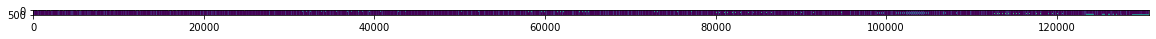

In [8]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

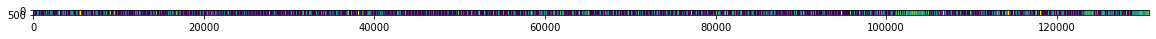

In [9]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

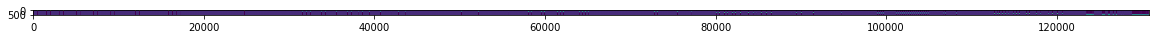

In [10]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

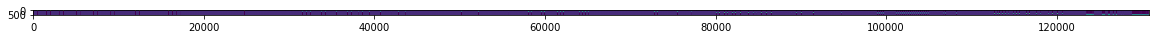

In [11]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [24]:
figsize = (20,15)
# figrange = (fx_s, fx_e, fy_s, fy_e)
figrange = (0, len(game_data['idx_to_key']), 0, 600)

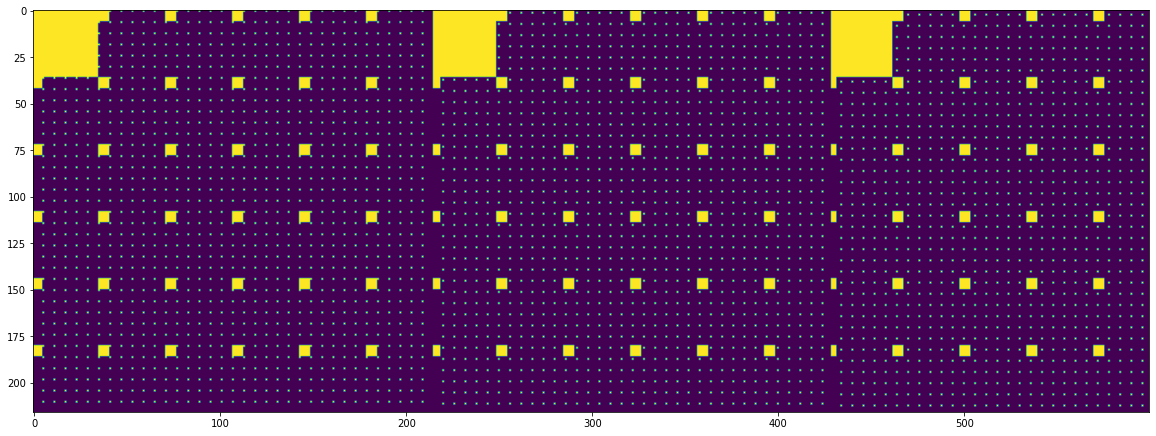

In [25]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

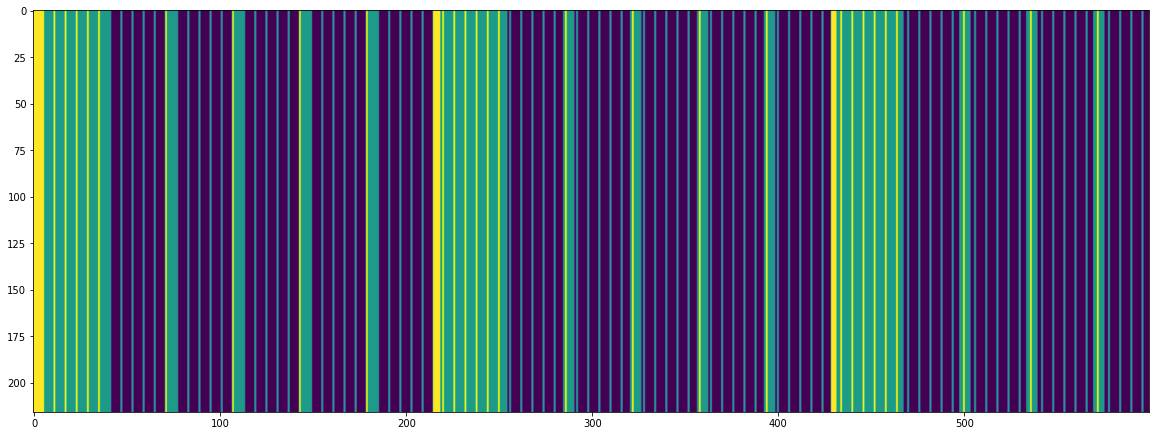

In [26]:
# all
plt.figure(figsize = figsize)
plt.imshow((xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

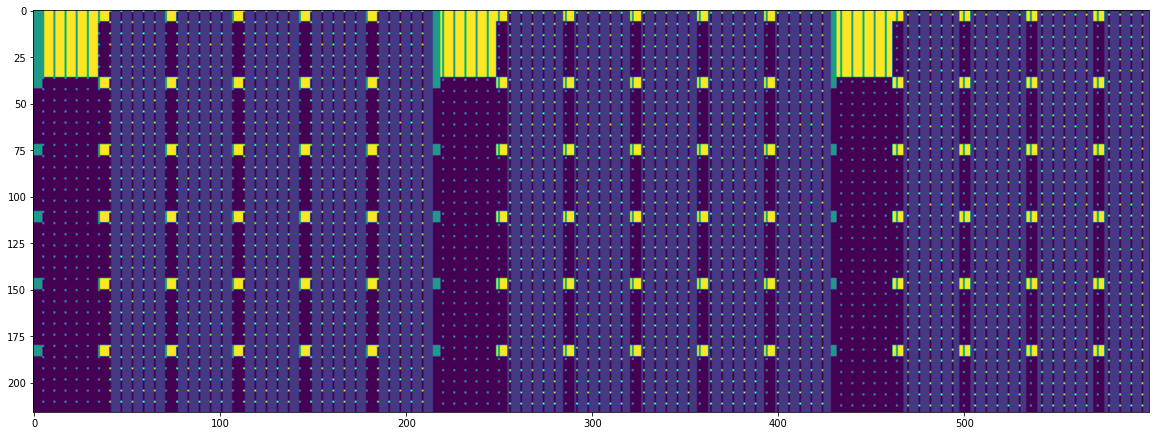

In [27]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

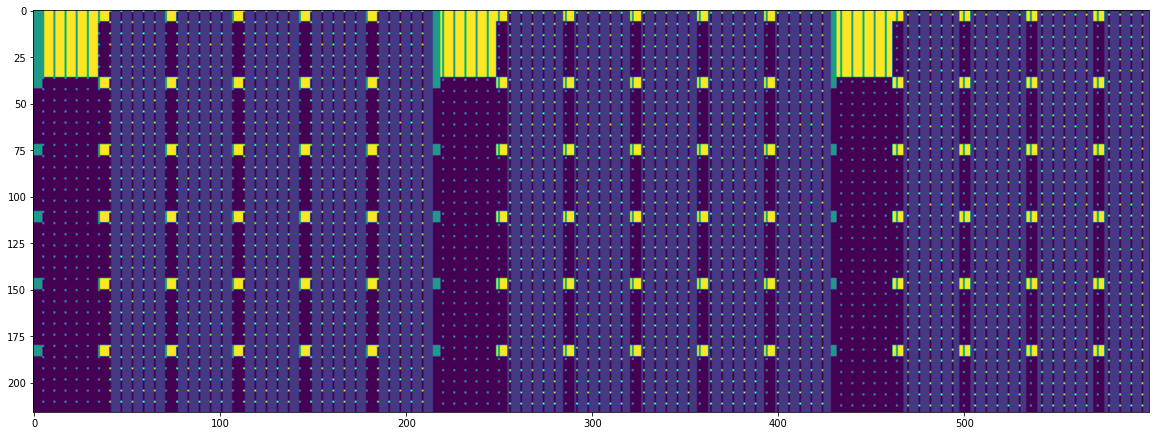

In [28]:
# all
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [17]:
Counter(list((xy/xyind).reshape(-1))).most_common()

[(0.9999999999999886, 28186368),
 (0.9999999999999883, 16507904),
 (2.4428543999999925e-93, 10569888),
 (2.4428543999999916e-93, 6190464),
 (7.999999999999974, 1509984),
 (1.302855679999998e-93, 1321236),
 (7.999999999999972, 884352),
 (1.3028556799999978e-93, 773808),
 (4.2666666666666595, 404460),
 (0.9999999999999888, 263424),
 (4.266666666666659, 236880),
 (2.442854399999993e-93, 98784),
 (7.999999999999975, 14112),
 (1.3028556799999984e-93, 12348),
 (4.266666666666661, 3780)]

## Dataset

In [18]:
### One embed per query!

class GameDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return self.query_support_size * self.key_support_size
    
    def __getitem__(self, idx):
        '''
        key_idx: (xy_i) * (xy.shape[1]=self.query_support_size) + (xy_j)
        '''
        x_i, y_j = idx//self.query_support_size, idx%self.query_support_size
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0
        
        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('key\n', x_i, self.raw_data['idx_to_key'][x_i])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
        
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        )    

game_dataset = GameDataset(raw_data=game_data, debug=True)
game_dataset[10] 
print('-----')
game_dataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square') ('red', 'solid', 'circle')
key
 0 ('red', 'void', 'square')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void', 'star'), ('red', 'void', 'hexagon'), ('red', 'dashed', 'square'), ('red', 'dashed', 'circle'), ('red', 'dashed', 'triangle'), ('red', 'dashed', 'star'), ('red', 'dashed', 'hexagon'), ('red', 'solid', 'square'), ('red', 'solid', 'circle'), ('red', 'solid', 'triangle'), ('red', 'solid', 'star'), ('red', 'solid', 'hexagon'), ('red', 'checkered', 'square'), ('red', 'checkered', 'circle'), ('red', 'checkered', 'triangle'), ('red', 'checkered', 'star'), ('red', 'checkered', 'hexagon'), ('red', 'dotted', 'square'), ('red', 'dotted', 'circle'), ('red', 'dotted', 'triangle'), ('red', 'dotted', 'star'), ('red', 'dotted', 'hexagon')]
-----
query
 7 : 0 8 ('red', 'void', 'square') ('red', 'dashed', 'star')
key
 0 ('red', 'void', 'square')
all matches 
 [('red', 'void', 'square'), ('re

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]))

In [19]:
class GameTestFullDataset(Dataset):
    
    def __init__(self, raw_data, debug=False):
        '''
        raw_data: object returned by gen_card_data.
        queries_with_shared_attr_only: bool.
        '''
        super().__init__()
        self.raw_data = raw_data
        self.debug = debug
        # y
        self.query_support_size = len(self.raw_data['idx_to_query'])
        # x
        self.key_support_size = len(self.raw_data['idx_to_key'])
        
    def __len__(self):
        return len(self.raw_data['idx_to_query'])
    
    def __getitem__(self, idx):
        '''
        key_idx: int. 0 to query_support_size-1
        '''
        y_j = idx
        x_i = torch.empty(1) # just a meaningless value
        all_matches = list(self.raw_data['query_to_keys'].get(y_j, {}).keys())
        gt = np.zeros(self.key_support_size)
        gt[all_matches] = 1.0

        if self.debug:
            yj1, yj2 = self.raw_data['idx_to_query'][y_j]
            print('query\n', y_j,":", yj1, yj2, self.raw_data['idx_to_key'][yj1], self.raw_data['idx_to_key'][yj2])
            print('all matches \n', [self.raw_data['idx_to_key'][m] for m in all_matches])
            
            
        return (
            idx, 
            torch.tensor([y_j]).long(), # query
            torch.tensor([x_i]).long(), # gt key
            torch.tensor(gt).long()     # all gt keys
        ) 
    
game_testdataset = GameTestFullDataset(raw_data=game_data, debug=True)
game_testdataset[10]
print('-----')
game_testdataset[7] # 7 has zero prob of being sampled

query
 10 : 0 11 ('red', 'void', 'square') ('red', 'solid', 'circle')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void', 'star'), ('red', 'void', 'hexagon'), ('red', 'dashed', 'square'), ('red', 'dashed', 'circle'), ('red', 'dashed', 'triangle'), ('red', 'dashed', 'star'), ('red', 'dashed', 'hexagon'), ('red', 'solid', 'square'), ('red', 'solid', 'circle'), ('red', 'solid', 'triangle'), ('red', 'solid', 'star'), ('red', 'solid', 'hexagon'), ('red', 'checkered', 'square'), ('red', 'checkered', 'circle'), ('red', 'checkered', 'triangle'), ('red', 'checkered', 'star'), ('red', 'checkered', 'hexagon'), ('red', 'dotted', 'square'), ('red', 'dotted', 'circle'), ('red', 'dotted', 'triangle'), ('red', 'dotted', 'star'), ('red', 'dotted', 'hexagon')]
-----
query
 7 : 0 8 ('red', 'void', 'square') ('red', 'dashed', 'star')
all matches 
 [('red', 'void', 'square'), ('red', 'void', 'circle'), ('red', 'void', 'triangle'), ('red', 'void'

(7,
 tensor([7]),
 tensor([0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]))

In [20]:
class GameDataModule(pl.LightningDataModule):
    
    def __init__(self, batch_size, raw_data, seen_train_xy, seen_val_xy, debug=False):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = GameDataset(raw_data=raw_data, debug=debug)
#         self.testdataset = GameTestFullDataset(raw_data=raw_data, debug=debug)
        self.seen_train_xy = seen_train_xy
        self.seen_val_xy = seen_val_xy
        self.setup_samplers()
        
    def setup_samplers(self):
        self.train_sampler = WeightedRandomSampler(
            weights=self.seen_train_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        ) 
        self.val_sampler = WeightedRandomSampler(
            weights=self.seen_val_xy.reshape(-1), num_samples=self.batch_size, replacement=True
        )
        
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train = self.dataset
            self.val = self.dataset
#         if stage == 'test' or stage is None:
#             self.test = self.testdataset
            
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train, batch_size=self.batch_size, shuffle=False, sampler=self.train_sampler
        )
        return train_loader
    
    def val_dataloader(self):
        val_loader = DataLoader(
            self.val, batch_size=self.batch_size,  shuffle=False, sampler=self.val_sampler
        )
        return val_loader
    
#     def test_dataloader(self):
#         test_loader = DataLoader(
#             self.test, batch_size=self.batch_size, shuffle=False
#         )
#         return test_loader  

## Model Architecture

In [21]:
def construct_full_model(hparams):
    '''
    return: nn.Module.
    '''
    # embeddings
    query_embed_X = ScaledEmbedding(hparams['query_support_size'], hparams['d_model'])
    key_embed_X = ScaledEmbedding(hparams['key_support_size'], hparams['d_model'])
    embed_dropout = nn.Dropout(hparams['embed_dropout'])
    
    # full model
    model = EncoderPredictor(
        inp_query_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', query_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        inp_key_layer = nn.Sequential(
            OrderedDict([
                ('scaled_embed', key_embed_X),
                ('embed_dropout', embed_dropout)
            ])
        ),
        classifier = nn.Sequential(
            OrderedDict([   
                ('linear1', nn.Linear(2*hparams['d_model'], hparams['d_model'])),
                ('nonLinear1', nn.ReLU()),
                ('linear-out', nn.Linear(hparams['d_model'], 1)),
            ])
        ) if not hparams['dotproduct_bottleneck'] else None, 
        
        key_support_size = hparams['key_support_size'],
        d_model = hparams['d_model'],
        debug = hparams['debug'],
    )
    
    return model

In [22]:
class ScaledEmbedding(nn.Module):

    def __init__(self, V, d_model):
        super(ScaledEmbedding, self).__init__()
        self.embedding = nn.Embedding(V, d_model)
        # scale embedding to have variance 0.01
        nn.init.normal_(self.embedding.weight, mean=0., std=(0.01)**(1/2))
        self.d_model = d_model

    def forward(self, tokens):
        '''
        tokens: shape (batch_size=b, len)
        '''
        # shape (b, len, d_model)
        embedded = self.embedding(tokens) * math.sqrt(self.d_model)
        if torch.max(embedded) > 2000.:
            import pdb; pdb.set_trace()
        return embedded

In [23]:
class EncoderPredictor(nn.Module):
    
    def __init__(self, inp_query_layer, inp_key_layer, classifier, key_support_size, d_model, debug=False):
        super().__init__()
        self.inp_query_layer = inp_query_layer
        self.inp_key_layer = inp_key_layer
        self.classifier = classifier
        self.key_support_size = key_support_size
        self.d_model = d_model
        
    def forward(self, X_query, X_key, val_bool, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1) if test bool, else (b, num matched cards) or None.
        '''
        if X_key is not None: assert X_query.shape == X_key.shape
        if val_bool:
            return self.forward_norm_support(X_query, debug=debug)
        else:
            assert X_key is not None, 'X_key should not be None for normalizing over minibatch keys.'
            return self.forward_norm_minibatch(X_query, X_key, debug=debug)

    def forward_norm_minibatch(self, X_query, X_key, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)
        
        # shape(b, d_model)
        key_repr = self.encode_key(X_key).squeeze(1)
        assert key_repr.shape == (b, self.d_model)

        if self.classifier:
            raise ValueError('Not supposed to use classifier!')
            # shape(b, b, d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, b, self.d_model)
            # shape(b, b, d_model)
            key_repr_tiled = key_repr.unsqueeze(0).expand(b, b, self.d_model)
            # shape(b, b, 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            assert query_key_concat.shape == (b, b, 2*self.d_model)
            # shape(b*b, 2*d_model)
            query_key_concat = query_key_concat.reshape(b*b, 2*self.d_model)
            # shape(b*b, 1)
            logits = self.classifier(query_key_concat)
            assert logits.shape == (b*b, 1)
            # shape(b, b)
            logits = logits.squeeze(1).reshape(b, b)
        else:
            # shape(b, b) dotproduct=logit matrix
            logits = torch.matmul(query_repr, key_repr.T)
        assert logits.shape == (b, b)
        
        # shape(b, b)
        return logits

    def forward_norm_support(self, X_query, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        
        # shape(b, d_model)
        query_repr = self.encode_query(X_query).squeeze(1)
        assert query_repr.shape == (b, self.d_model)

        # shape(size(support), d_model)
        keys_repr = self.encode_all_keys()
        assert keys_repr.shape == (self.key_support_size, self.d_model)
        
        if self.classifier:
            # shape(b, size(support), d_model)
            query_repr_tiled = query_repr.unsqueeze(1).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), d_model)
            key_repr_tiled = keys_repr.unsqueeze(0).expand(b, self.key_support_size, self.d_model)
            # shape(b, size(support), 2*d_model)
            query_key_concat = torch.cat([query_repr_tiled, key_repr_tiled], dim=2)
            # shape(b*size(support), 2*d_model)
            query_key_concat = query_key_concat.reshape(b*self.key_support_size, 2*self.d_model)
            # shape(b*size(support), 1)
            logits = self.classifier(query_key_concat)
            # shape(b, size(support))
            logits = logits.squeeze(1).reshape(b, self.key_support_size)
        else:
            # shape(b, size(support)) dotproduct=logit matrix
            logits = torch.matmul(query_repr, keys_repr.T)
        assert logits.shape == (b, self.key_support_size)
        
        # shape(b, size(support)) 
        return logits

    def encode_query(self, X):
        '''
        X: (batch_size=b,1)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_query_layer(X)
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed     
        
    def encode_key(self, X):
        '''
        X: (batch_size=b)
        '''
        b = X.shape[0] 
        # shape(b, 1, embed_dim)
        inp_embed = self.inp_key_layer(X) 
        assert inp_embed.shape == (b, 1, self.d_model)
        return inp_embed  

    def encode_all_keys(self):
        
        # shape(size(support), embed_dim)
        all_embed = self.inp_key_layer.scaled_embed.embedding.weight
        assert all_embed.requires_grad == True
        assert all_embed.shape == (self.key_support_size, self.d_model)
        
        return all_embed

## Loss, Metric

In [24]:
class InfoCELoss(nn.Module):
    '''
    InfoCE Loss on a (b, b) logits matrix with Temperature scaling
    '''

    def __init__(self, temperature_const=1.0):
        super().__init__()
        self.temperature_const = temperature_const
        self.CE_loss = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, logits, debug=False):
        '''
        logits: shape (batch_size=b, b)
        '''
        assert logits.shape[0] == logits.shape[1]
        b = logits.shape[0]
        
        logits /= self.temperature_const
        
        labels = torch.arange(b).type_as(logits).long()
        sum_loss_per_row = self.CE_loss(logits, labels)
        sum_loss_per_col = self.CE_loss(logits.T, labels)
        
        if debug:
            print('sum_loss_per_row=',sum_loss_per_row)
            print('sum_loss_per_col=',sum_loss_per_col)

        loss = (sum_loss_per_row + sum_loss_per_col) * 0.5
        return loss


# ---------------------------    
loss_criterion = InfoCELoss(temperature_const=0.1)

logits = torch.tensor([
    [1.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))
print('-------------')
logits = torch.tensor([
    [3.,2.,3.],
    [6.,7.,4.],
    [5.,8.,9.]
])
print('avg loss=',loss_criterion(logits, True))


# ref
# sum_loss_per_row= tensor(20.0001)
# sum_loss_per_col= tensor(60.0001)
# avg loss= tensor(40.0001)
# -------------
# sum_loss_per_row= tensor(0.6933)
# sum_loss_per_col= tensor(40.0001)
# avg loss= tensor(20.3467)

sum_loss_per_row= tensor(20.0001)
sum_loss_per_col= tensor(60.0001)
avg loss= tensor(40.0001)
-------------
sum_loss_per_row= tensor(0.6933)
sum_loss_per_col= tensor(40.0001)
avg loss= tensor(20.3467)


In [25]:
class ThresholdedMetrics(nn.Module):
    
    def __init__(self, raw_data):
        '''
        tot_k: total number of candidates. e.g. 81 cards
        '''
        super().__init__()
        self.raw_data = raw_data
        self.key_support_size = len(self.raw_data['idx_to_key'])
        self.threshold = 1.0 / (self.key_support_size)
        self.softmax = nn.Softmax(dim=1)

    def breakdown_errors(self, X_query, corrects):
        '''
        X_query: shape (b,1) (if one embed per query)
        corrects: shape (b, support size)
        '''
        b = X_query.shape[0]
        assert corrects.shape == (b, self.key_support_size)
        
        X_query_list = X_query.squeeze(-1)
        wrongs = (1 - corrects).cpu().numpy()
        
        num_matched_concepts = [
             self.raw_data['query_to_keys'].get(X_query_list[batch_i].item(), {}).get(card_idx, 0)
            for batch_i in range(b) for card_idx in range(self.key_support_size)  
        ]
        
        num_matched_concepts = np.array(num_matched_concepts).reshape(b, self.key_support_size)
        assert num_matched_concepts.shape == wrongs.shape
        
        wrongs_mask = wrongs.reshape(-1).tolist()
        num_matched_concepts = num_matched_concepts.reshape(-1).tolist()

        error_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        total_count_by_num_matched_concepts = {k:0 for k in range(num_attributes)}
        for w,k in zip(wrongs_mask, num_matched_concepts):
            if w == 1:
                error_count_by_num_matched_concepts[k] += 1
            total_count_by_num_matched_concepts[k] += 1    

        error_counts, total_counts = {}, {}
        for k in range(num_attributes):
            err_ct = error_count_by_num_matched_concepts[k]
            tot_ct = total_count_by_num_matched_concepts[k]
            error_counts[f'error_rate_for_{k}_matched_concepts'] = 0 if tot_ct == 0 else (err_ct *1.0 / tot_ct)
            total_counts[f'total_count_for_{k}_matched_concepts'] = tot_ct

        return {**error_counts, **total_counts}    
    
    def forward(self, X_query, logits, X_keys, full_test_bool=False, breakdown_errors_bool=False, debug=False):
        b = X_query.shape[0]
        assert X_query.shape == (b, 1)
        b, key_support_size = logits.shape
        assert key_support_size == self.key_support_size
        assert logits.shape == X_keys.shape
        
        if full_test_bool:
            # filter down to query cards with >0 true matches
            queryIdxs_with_nonzero_matches = list(self.raw_data['query_to_keys'].keys())
            X_query_flat = X_query.squeeze(-1)
            fil = torch.stack([(X_query_flat == qId) for qId in queryIdxs_with_nonzero_matches], dim=1).any(dim=1)
            assert fil.shape == (b, )
            
            # queries with shared attributes
            fil_metrics = self.compute_metrics(X_query[fil], logits[fil], X_keys[fil], breakdown_errors_bool, debug)
            fil_metrics = {'nonNullQueries_'+k:fil_metrics[k] for k in fil_metrics}
            
            # queries without shared attributes
            not_fil = torch.logical_not(fil)
            not_fil_metrics = self.compute_metrics(X_query[not_fil], logits[not_fil], X_keys[not_fil], breakdown_errors_bool, debug)
            not_fil_metrics = {'NullQueries_'+k:not_fil_metrics[k] for k in not_fil_metrics}
            
            # all queries
            all_metrics = self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
            
            return {**fil_metrics, **not_fil_metrics, **all_metrics}
        else:
            return self.compute_metrics(X_query, logits, X_keys, breakdown_errors_bool, debug)
    
    def compute_metrics(self, X_query, logits, X_keys, breakdown_errors_bool=False, debug=False):
        '''
        X_query: shape (b,1) (if one embed per query)
        logits: shape (b, support size)
        X_keys: shape (b, support size). value 1.0 at where card matches. value 0 otherwise.
        '''
        b, key_support_size = logits.shape
        
        # model predictions, shape (b, support size)
        binary_predictions = (self.softmax(logits) >= self.threshold).type(torch.float)
        # ground truth, shape (b, support size)
        gt = X_keys
        # correct predictions, shape (b, support size)
        corrects = (binary_predictions == gt).type(torch.float)
        
        # accuracy, computed per query, average across queries
        # (b,)
        accuracy_row = torch.sum(corrects, dim=1) / key_support_size
        # scalar
        accuracy_meanrows = torch.mean(accuracy_row)
        # accuracy, computed per query-key, average across all
        accuracy_all = torch.sum(corrects) / (b * key_support_size)
        
        # precision, computed per query, average across queries
        # (b,)
        precision_row = torch.sum((corrects * binary_predictions), dim=1) / torch.sum(binary_predictions, dim=1)
        # scalar
        precision_meanrows = torch.mean(precision_row)
        # precision, computed per query-key, average across all
        precision_all = torch.sum((corrects * binary_predictions)) / torch.sum(binary_predictions)

        # recall, computed per query, average across queries
        # (b,)
        recall_row = torch.sum((corrects * gt), dim=1) / torch.sum(gt, dim=1)
        # scalar
        recall_meanrows = torch.mean(recall_row)
        # recall, computed per query-key, average across all
        recall_all = torch.sum((corrects * gt)) / torch.sum(gt)
        
        # f1, computed per query, average across queries
        # (b,)
        f1_row = 2 * (precision_row * recall_row) / (precision_row + recall_row)
        # scalar
        f1_meanrows = torch.mean(f1_row)
        # f1, computed per query-key, average across all
        f1_all = (precision_all * recall_all) / (precision_all + recall_all)
        
        if breakdown_errors_bool:
            error_breakdown_by_num_matched_concepts = self.breakdown_errors(X_query, corrects)
        else:
            error_breakdown_by_num_matched_concepts = {} 
            
        if debug:
            print('####################################################')
            print('Metrics Per Query:')
            print('accuracy_rows', accuracy_row)
            print('precision_row', precision_row)
            print('recall_row', recall_row)
            print('f1_row', f1_row)
            print('####################################################')
            print('Metrics Averaged Across Queries')
            print('accuracy_meanrows', accuracy_meanrows)
            print('precision_meanrows', precision_meanrows)
            print('recall_meanrows', recall_meanrows)
            print('f1_meanrows', f1_meanrows)
            print('####################################################')
            print('Metrics Averaged Across All Query-Key Pairs:')
            print('accuracy_all', accuracy_all)
            print('precision_all', precision_all)
            print('recall_all', recall_all)
            print('f1_all', f1_all)
            print('####################################################')
            print('error_breakdown', error_breakdown_by_num_matched_concepts)
            
        metrics = {
            'accuracy_by_Query': accuracy_meanrows,
            'precision_by_Query': precision_meanrows,
            'recall_by_Query': recall_meanrows,
            'f1_by_Query': f1_meanrows,
            'accuracy_by_QueryKey': accuracy_all,
            'precision_by_QueryKey': precision_all,
            'recall_by_QueryKey': recall_all,
            'f1_by_QueryKey': f1_all
        }
        metrics = {
            **metrics, **error_breakdown_by_num_matched_concepts
        }
        return metrics


def test_metric_module():
    key_support_size=3
    thresh=1./key_support_size

    m_f = ThresholdedMetrics(raw_data=game_data)
    m_f.key_support_size = 3

    logits = torch.tensor(
        [
            [thresh, thresh, thresh],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    print('----------------------------------------------')
    
    logits = torch.tensor(
        [
            [0.4, 0.2, 0.4],
            [thresh, thresh, thresh],
            [thresh, thresh, thresh]
        ]
    )
    X_keys = torch.tensor(
        [
            [1,0,0],
            [0,1,0],
            [1,1,1]
        ]
    )

    print(m_f(None, logits, X_keys, debug=True))
    
    
# test_metric_module()

# reference output
# accuracy_row tensor([0.3333, 0.3333, 1.0000])
# precision_row tensor([0.3333, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.5000, 0.5000, 1.0000])
# {'accuracy': tensor(0.5556), 'precision': tensor(0.5556), 'recall': tensor(1.), 'f1': tensor(0.6667)}
# ----------------------------------------------
# accuracy_row tensor([0.6667, 0.3333, 1.0000])
# precision_row tensor([0.5000, 0.3333, 1.0000])
# recall_row tensor([1., 1., 1.])
# f1_row tensor([0.6667, 0.5000, 1.0000])
# {'accuracy': tensor(0.6667), 'precision': tensor(0.6111), 'recall': tensor(1.), 'f1': tensor(0.7222)}

## Training Module

In [26]:
# Build Lightning Module
# https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=UIXLW8CO-W8w

thresholded_metrics = ThresholdedMetrics(raw_data=game_data)

class TrainModule(pl.LightningModule):
    
    def __init__(self, hparams, gt_distributions):
        '''
        hparams: dictionary of hyperparams
        gt_distributions: dictionary that stores the groundtruth 'xy', 'xyind' distributions.
                         each is a key_support_size by query_support_size matrix that sums up to 1.0
        '''
        super().__init__()
        self.hparams = hparams
        self.debug = hparams['debug']
        self.save_hyperparameters()
        
        self.model = construct_full_model(hparams)
        self.loss_criterion = InfoCELoss(temperature_const=self.hparams['loss_temperature_const'])
        self.metrics = thresholded_metrics

        self.key_support_size = self.hparams['key_support_size']
        self.query_support_size = self.hparams['query_support_size']
        
        # for pulling model p(x,y) and p(x,y)/[pxpy]
        self.populate_logits_matrix = hparams['populate_logits_matrix']
        if self.populate_logits_matrix:
            self.register_buffer(
                name='model_logits_matrix',
                tensor= torch.zeros(hparams['key_support_size'], hparams['query_support_size'])
            )
            self.setup_gt_distributions(gt_distributions)
        
    def log_metrics(self, metrics_dict):
        for k, v in metrics_dict.items():
            self.log(k, v)
            
    def get_max_memory_alloc(self):
        devices_max_memory_alloc = {}
        for i in range(torch.cuda.device_count()):
            device = torch.device(f'cuda:{i}')
            devices_max_memory_alloc[device] = torch.cuda.max_memory_allocated(device) / 1e6
            torch.cuda.reset_max_memory_allocated(device)
        return devices_max_memory_alloc
    
    ###################################################
    
    def forward(self, X_query, X_key, X_keys, val_bool, full_test_bool=False, debug=False):
        '''
        X_query: (b, 1)
        X_key: (b, 1)
        X_keys: (b, key_support_size) 1s and 0s.
        test_bool: boolean.
        '''
        batch_size = X_query.shape[0]
        
        # ToDo batch_size_b
        
        # shape (b,support) if test_bool else (b, b)
        logits = self.model(X_query, X_key, val_bool, debug=debug)
        # scalar
        loss = None if val_bool else self.loss_criterion(logits, debug=debug)
        # scalar
        metrics = self.metrics(
            logits=logits, X_keys=X_keys, X_query=X_query, 
            debug=debug, full_test_bool=full_test_bool, breakdown_errors_bool=True, 
        ) if val_bool else None

        return logits, loss, metrics
    
    ###################################################
    
    def setup_gt_distributions(self, gt_distributions):
        '''called once during init to setup groundtruth distributions'''
        assert gt_distributions['xy'].shape == gt_distributions['xyind'].shape
        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy',
            tensor= torch.tensor(gt_distributions['xy'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xyind',
            tensor= torch.tensor(gt_distributions['xyind'])
        )        
        # (key_support_size, query_support_size)
        self.register_buffer(
            name='gt_xy_div_xyind',
            tensor= self.gt_xy/self.gt_xyind
        )
        # scalar
        self.register_buffer(
            name='one',
            tensor= torch.tensor([1.0])
        )   
        # scalar
        self.register_buffer(
            name='gt_mi',
            tensor= self.compute_mutual_information(self.gt_xy, self.gt_xy_div_xyind)
        ) 
   
    
    def populate_model_logits_matrix(self, query_idx, logits):
        '''
        query_idx: shape (b,)
        logits: shape(b, key_support_size)
        '''  
        assert query_idx.shape[0] == logits.shape[0]
        b = query_idx.shape[0]
        assert logits.shape[1] == self.key_support_size
        for i in range(b):
            self.model_logits_matrix[:,query_idx[i]] = logits[i]
    
    def compute_mutual_information(self, xy, xy_div_xyind):
        '''
        xy: p(xy). shape(b, key_support_size)
        xy_div_xyind_hat: p(xy)/[p(x)(y)].
                          shape(b, key_support_size)
        '''
        assert torch.isclose(torch.sum(xy), self.one.type_as(xy))
        assert xy.shape == xy_div_xyind.shape == (
            self.key_support_size, self.query_support_size
        )
        pmi = torch.log(xy_div_xyind)
        mi = torch.sum(xy * pmi)
        return mi
    
    def pull_model_distribution(self, debug=True):

        # sanity check
        sum_logits = torch.sum(self.model_logits_matrix)
        assert sum_logits != 0.0
        
        if debug:
            print('Sum of model logits matrix\n', sum_logits)
            print('Number of model logits with zero value\n', torch.sum(self.model_logits_matrix == 0.0)) 
            print('Variance of model logits\n', torch.var(self.model_logits_matrix))
        
        # estimate the full distribution
        # hat( k * pxy/(pxpy)
        f = torch.exp(self.model_logits_matrix)
        # hat( k * pxy)
        xy_hat = f * self.gt_xyind
        # hat( pxy)
        xy_hat = (xy_hat / torch.sum(xy_hat))
        
        # estimate exp(pmi)
        # hat(k)
        k_hat = torch.sum(f) / torch.sum(self.gt_xy_div_xyind)
        # hat(pxy/(pxpy)
        xy_div_xyind_hat = (f / k_hat)
        if torch.any(torch.isnan(xy_div_xyind_hat)):
            import pdb; pdb.set_trace()
        
        # estimate MI
        # scalar
        mi_hat = self.compute_mutual_information(xy_hat, xy_div_xyind_hat)
        # scalar
        mi_gt_minus_hat = self.gt_mi - mi_hat
        
        # estimate KL divergence
        kl_div_val = F.kl_div(torch.log(xy_hat), self.gt_xy)

        # estimate ranks
        xy_hat = xy_hat.detach().cpu().numpy()
        xy_div_xyind_hat = xy_div_xyind_hat.detach().cpu().numpy()
        # hat(pxy rank)
        xy_hat_rank = np.linalg.matrix_rank(xy_hat)
        # hat(pxy/(pxpy rank)
        xy_div_xyind_hat_rank = np.linalg.matrix_rank(xy_div_xyind_hat) 
        
        pulled_distribution_results = {
            'xy_hat':xy_hat,
            'xy_div_xyind_hat':xy_div_xyind_hat,
            'xy_hat_rank':xy_hat_rank,
            'xy_div_xyind_hat_rank':xy_div_xyind_hat_rank,
            'mi_hat':mi_hat,
            'mi_gt_minus_hat':mi_gt_minus_hat,
            'kl_div':kl_div_val
        }
        
        return pulled_distribution_results

    ###################################################
    
    def training_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        # scalar
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        # dict
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('train step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\nX_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:\n', [(m,metrics[m]) for m in metrics]
            )
        
        # log
        step_metrics = {**{'train_loss': loss}, **{'train_'+m:metrics[m] for m in metrics}}
        self.log_metrics(step_metrics)
        return loss
    
    def validation_step(self, batch, batch_nb):
        
        # _, (b, 1), (b, 1), (b, support size)
        _, X_query, X_key, X_keys = batch
        _, loss, _ = self(X_query, X_key, None, val_bool=False, debug=self.debug)
        _, _, metrics = self(X_query, None, X_keys, val_bool=True, debug=self.debug)
        
        if self.debug:
            print('-----------------------------')
            print('validation step')
            print(Counter(torch.sum(X_keys, dim=1).tolist()).most_common())
            print(
                'X_query:',X_query[0], '\X_key:',
                X_key[0], '\nloss:', loss, '\nmetrics:', [(m,metrics[m]) for m in metrics]
            )
            
        # log 
        step_metrics = {**{'val_loss': loss}, **{'val_'+m:metrics[m] for m in metrics}}
        devices_max_memory_alloc = self.get_max_memory_alloc()
        for device, val in devices_max_memory_alloc.items():
            step_metrics[f'step_max_memory_alloc_cuda:{device}'] = val
        self.log_metrics(step_metrics)
        return step_metrics
    
    def test_step(self, batch, batch_nb):
        
        # (b,1), (b,1), _, (b, support size)
        query_idx, X_query, _, X_keys = batch
        
        # compute scores for all keys
        # shape(b, key_support_size), _, dictionary
        logits, _, metrics = self(X_query, None, X_keys, val_bool=True, full_test_bool=True, debug=self.debug)
        
        if self.populate_logits_matrix:
            self.populate_model_logits_matrix(query_idx, logits)
        
        # log
        step_metrics = {'test_'+m:metrics[m] for m in metrics}
        self.log_metrics(step_metrics)
        return step_metrics 
    
    ###################################################
    
    def aggregate_metrics_at_epoch_end(self, outputs):
        # log metrics
        epoch_metrics = {}
        metric_names = outputs[0].keys()
        for m in metric_names:
            if not ('max_memory_alloc_cuda' in m or 'count' in m or 'rate' in m):
                epoch_metrics['avg_'+m] = torch.stack([x[m] for x in outputs]).mean()
            elif '_matched_concepts' in m:
                epoch_metrics['avg_'+m] = np.mean([x[m] for x in outputs])
        self.log_metrics(epoch_metrics)
        return epoch_metrics         
    
    def validation_epoch_end(self, outputs):
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        return averaged_metrics
    
    def test_epoch_end(self, outputs):        
        averaged_metrics = self.aggregate_metrics_at_epoch_end(outputs)
        try:
            assert 'avg_test_error_rate_for_1_matched_concepts' in averaged_metrics
        except:
            import pdb; pdb.set_trace()
            
        return averaged_metrics
    
    ###################################################
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(
            params=self.model.parameters(),
            lr=self.hparams['lr'],
            betas=(
                self.hparams['adam_beta1'], self.hparams['adam_beta2']),
            eps=self.hparams['adam_epsilon'],
            weight_decay=self.hparams['adam_weight_decay']
        )
        return opt

## hparams, init train module

In [27]:
# W&B References
# https://docs.wandb.com/library/integrations/lightning
# colab example
# https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch-lightning/Supercharge_your_Training_with_Pytorch_Lightning_%2B_Weights_%26_Biases.ipynb
# step by step guide
# https://wandb.ai/cayush/pytorchlightning/reports/Use-Pytorch-Lightning-with-Weights-Biases--Vmlldzo2NjQ1Mw


# Distributed Weighted Sampler
# https://discuss.pytorch.org/t/how-to-use-my-own-sampler-when-i-already-use-distributedsampler/62143/8
# https://github.com/PyTorchLightning/pytorch-lightning/discussions/3716#discussioncomment-238296

# torch lightning -- how sampler is added or removed
# https://pytorch-lightning.readthedocs.io/en/stable/multi_gpu.html?highlight=sampler#remove-samplers


hparams = {
    # game difficulty
    'num_attributes': num_attributes,
    'num_attr_vals': num_attr_vals,
    # distribution
    'distribution_epsilon': distribution_epsilon,
    'xy_size': xy.shape,
    # 
    'batch_size': 128,
    # Arch
    'key_support_size': len(game_data['idx_to_key']),
    'query_support_size': len(game_data['idx_to_query']),
    # embedding
    'd_model': 16,
    'embed_dropout': 0.0,
    # final prediction
    'dotproduct_bottleneck':True,
    # loss
    'loss_temperature_const': 1.0,
    # optimizer
    'lr': 0.001,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'warmup_steps': 12000,
    'adam_weight_decay':0,
    'gradient_clip_val': 0,
    # others
    'debug':False,
    'populate_logits_matrix': True
}

pl.seed_everything(42)

# model
trainmodule =  TrainModule(hparams, gt_distributions={'xy':xy, 'xyind':xyind})# , raw_data=game_data)
model_summary = pl.core.memory.ModelSummary(trainmodule, mode='full')
print(model_summary,'\n')

# data
game_datamodule = GameDataModule(
    batch_size = hparams['batch_size'],
    raw_data = game_data,
    seen_train_xy = xy,
    seen_val_xy = xy,
    debug=hparams['debug']
)

# logger
run_name = 'CardGame:OR;attr{}-val{};epsilon{};d_model{};params{}K;dot-product'.format(num_attributes, num_attr_vals, str(distribution_epsilon), hparams['d_model'], round(max(model_summary.param_nums)/1000,2))
project_name = 'ContrastiveLearning-cardgame-Scaling'
wd_logger = WandbLogger(name=run_name, project=project_name)
print('RUN NAME :\n', run_name)
# check point path
ckpt_dir_PATH = os.path.join('checkpoints', project_name, run_name)

Global seed set to 42


   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 126 K 
1  | model.inp_query_layer                        | Sequential         | 124 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 124 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 124 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 2.0 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 2.0 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 2.0 K 
8  | loss_criterion                               | InfoCELoss         | 0     
9  | loss_criterion.CE_loss                       | CrossEntropyLoss   | 0     
10 | metrics                      

## Run Training

In [28]:
# checkpoints
os.makedirs(ckpt_dir_PATH, exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    monitor='avg_val_accuracy_by_Query',
    dirpath=ckpt_dir_PATH,
    filename='{epoch:02d}-{val_loss:.2f}',
    save_top_k=6,
    save_last=True,
    mode='max',
)

# trainer
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=50000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

#fit
with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
<ipython-input-28-49cb5c6af813>:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


wandb: WARNING Serializing object of type ndarray that is 7750112 bytes
wandb: WARNING Serializing object of type ndarray that is 7750112 bytes

   | Name                                         | Type               | Params
-------------------------------------------------------------------------------------
0  | model                                        | EncoderPredictor   | 126 K 
1  | model.inp_query_layer                        | Sequential         | 124 K 
2  | model.inp_query_layer.scaled_embed           | ScaledEmbedding    | 124 K 
3  | model.inp_query_layer.scaled_embed.embedding | Embedding          | 124 K 
4  | model.inp_query_layer.embed_dropout          | Dropout            | 0     
5  | model.inp_key_layer                          | Sequential         | 2.0 K 
6  | model.inp_key_layer.scaled_embed             | ScaledEmbedding    | 2.0 K 
7  | model.inp_key_layer.scaled_embed.embedding   | Embedding          | 2.0 K 
8  | loss_criterion                              

Validation sanity check:   0%|          | 0/1 [00:00<?, ?it/s]

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]                        

/home/user/miniconda/lib/python3.8/site-packages/torch/cuda/memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  1.24it/s, loss=648, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  1.84it/s, loss=647, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=648, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=645, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 1/2 [00:00<00:00,  2.69it/s, loss=648, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 1/2 [00:00<00:00,  2.77it/s, loss=649, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=648, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=647, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=646, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 1/

Validating: 0it [00:00, ?it/s]
Epoch 68:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=641, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 69:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=641, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 70:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=641, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 71:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=641, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 72:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=641, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 73:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=641, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 74:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=641, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 75:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=641, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 76:  50%|█████     | 1/2 [00:00<00:00,  2.61it/s, loss=641, v_num=zp9m]
Validating: 0it [00

Validating: 0it [00:00, ?it/s]
Epoch 135:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=638, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 136:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=637, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 137:  50%|█████     | 1/2 [00:00<00:00,  2.46it/s, loss=637, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 138:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=637, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 139:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=637, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 140:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=638, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 141:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=638, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 142:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=638, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 143:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=638, v_num=zp9m]
Validating

Epoch 201:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=633, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 202:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=633, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 203:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=634, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 204:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=633, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 205:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=633, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 206:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=633, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 207:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=633, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 208:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=632, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 209:  50%|█████     | 1/2 [00:00<00:00,  3.17it/s, loss=633, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 210:

Epoch 268:  50%|█████     | 1/2 [00:00<00:00,  3.15it/s, loss=630, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 269:  50%|█████     | 1/2 [00:00<00:00,  2.86it/s, loss=630, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 270:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=630, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 271:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=631, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 272:  50%|█████     | 1/2 [00:00<00:00,  3.05it/s, loss=631, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 273:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=630, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 274:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=630, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 275:  50%|█████     | 1/2 [00:00<00:00,  3.48it/s, loss=630, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 276:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=630, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 277:

Validating: 0it [00:00, ?it/s]
Epoch 335:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=626, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 336:  50%|█████     | 1/2 [00:00<00:00,  2.75it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 337:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 338:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 339:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 340:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 341:  50%|█████     | 1/2 [00:00<00:00,  2.26it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 342:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 343:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=626, v_num=zp9m]
Validating

Epoch 401:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=624, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 402:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=624, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 403:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=624, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 404:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 405:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 406:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 407:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 408:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 409:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=625, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 410:

Epoch 468:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=623, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 469:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=623, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 470:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=623, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 471:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=622, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 472:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=622, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 473:  50%|█████     | 1/2 [00:00<00:00,  3.06it/s, loss=622, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 474:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=622, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 475:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=622, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 476:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=622, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 477:

Validating: 0it [00:00, ?it/s]
Epoch 535:  50%|█████     | 1/2 [00:00<00:00,  3.22it/s, loss=620, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 536:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=620, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 537:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=620, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 538:  50%|█████     | 1/2 [00:00<00:00,  3.13it/s, loss=620, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 539:  50%|█████     | 1/2 [00:00<00:00,  3.04it/s, loss=619, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 540:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=620, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 541:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s, loss=619, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 542:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=619, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 543:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=619, v_num=zp9m]
Validating

Epoch 601:  50%|█████     | 1/2 [00:00<00:00,  2.65it/s, loss=618, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 602:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=618, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 603:  50%|█████     | 1/2 [00:00<00:00,  2.38it/s, loss=618, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 604:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=618, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 605:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=618, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 606:  50%|█████     | 1/2 [00:00<00:00,  2.25it/s, loss=618, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 607:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=618, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 608:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=618, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 609:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=617, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 610:

Epoch 668:  50%|█████     | 1/2 [00:00<00:00,  2.21it/s, loss=614, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 669:  50%|█████     | 1/2 [00:00<00:00,  2.90it/s, loss=614, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 670:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=614, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 671:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=615, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 672:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=614, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 673:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=614, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 674:  50%|█████     | 1/2 [00:00<00:00,  2.70it/s, loss=614, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 675:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=614, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 676:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=614, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 677:

Validating: 0it [00:00, ?it/s]
Epoch 735:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=610, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 736:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=610, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 737:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=609, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 738:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=609, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 739:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=608, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 740:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=608, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 741:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=609, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 742:  50%|█████     | 1/2 [00:00<00:00,  3.10it/s, loss=608, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 743:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=608, v_num=zp9m]
Validating

Epoch 801:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=607, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 802:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=607, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 803:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=607, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 804:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=607, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 805:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=607, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 806:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=607, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 807:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=607, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 808:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=606, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 809:  50%|█████     | 1/2 [00:00<00:00,  2.88it/s, loss=606, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 810:

Epoch 868:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=603, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 869:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=603, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 870:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=602, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 871:  50%|█████     | 1/2 [00:00<00:00,  2.43it/s, loss=602, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 872:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=602, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 873:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=603, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 874:  50%|█████     | 1/2 [00:00<00:00,  1.77it/s, loss=603, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 875:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=603, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 876:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=602, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 877:

Validating: 0it [00:00, ?it/s]
Epoch 935:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=599, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 936:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s, loss=599, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 937:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=598, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 938:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=598, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 939:  50%|█████     | 1/2 [00:00<00:00,  3.50it/s, loss=598, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 940:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=598, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 941:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=598, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 942:  50%|█████     | 1/2 [00:00<00:00,  3.42it/s, loss=598, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 943:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=598, v_num=zp9m]
Validating

Epoch 1001:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=589, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1002:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=589, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1003:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=590, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1004:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=590, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1005:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=590, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1006:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=589, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1007:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=589, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1008:  50%|█████     | 1/2 [00:00<00:00,  3.67it/s, loss=589, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1009:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=589, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1067:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=582, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1068:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=582, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1069:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=581, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1070:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=581, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1071:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=581, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1072:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=580, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1073:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=580, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1074:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=580, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1075:  50%|█████     | 1/2 [00:00<00:00,  2.71it/s, loss=580, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1133:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=575, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1134:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=575, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1135:  50%|█████     | 1/2 [00:00<00:00,  2.95it/s, loss=575, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1136:  50%|█████     | 1/2 [00:00<00:00,  3.08it/s, loss=575, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1137:  50%|█████     | 1/2 [00:00<00:00,  2.51it/s, loss=574, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1138:  50%|█████     | 1/2 [00:00<00:00,  2.78it/s, loss=574, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1139:  50%|█████     | 1/2 [00:00<00:00,  2.68it/s, loss=574, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1140:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=573, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1141:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=573, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1199: 100%|██████████| 2/2 [00:00<00:00,  4.34it/s, loss=566, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1200:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=566, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1201:  50%|█████     | 1/2 [00:00<00:00,  3.66it/s, loss=566, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1202:  50%|█████     | 1/2 [00:00<00:00,  2.92it/s, loss=565, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1203:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=566, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1204:  50%|█████     | 1/2 [00:00<00:00,  2.87it/s, loss=565, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1205:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=565, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1206:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=564, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1207:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=565, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1265:  50%|█████     | 1/2 [00:00<00:00,  3.31it/s, loss=557, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1266:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=557, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1267:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=558, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1268:  50%|█████     | 1/2 [00:00<00:00,  2.73it/s, loss=558, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1269:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=559, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1270:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=558, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1271:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=558, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1272:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=558, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1273:  50%|█████     | 1/2 [00:00<00:00,  2.59it/s, loss=558, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1331:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=554, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1332:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=554, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1333:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=554, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1334:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=554, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1335:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=555, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1336:  50%|█████     | 1/2 [00:00<00:00,  3.47it/s, loss=555, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1337:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=555, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1338:  50%|█████     | 1/2 [00:00<00:00,  3.16it/s, loss=555, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1339:  50%|█████     | 1/2 [00:00<00:00,  3.36it/s, loss=555, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1397:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=545, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1398:  50%|█████     | 1/2 [00:00<00:00,  3.52it/s, loss=546, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1399: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s, loss=546, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1400:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=546, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1401:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=546, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1402:  50%|█████     | 1/2 [00:00<00:00,  3.28it/s, loss=546, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1403:  50%|█████     | 1/2 [00:00<00:00,  3.38it/s, loss=545, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1404:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=546, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1405:  50%|█████     | 1/2 [00:00<00:00,  3.56it/s, loss=545, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1463:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=534, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1464:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=533, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1465:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=533, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1466:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=533, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1467:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=534, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1468:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=533, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1469:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=533, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1470:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=532, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1471:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=532, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1529:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=530, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1530:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=530, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1531:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=530, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1532:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=529, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1533:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=529, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1534:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=528, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1535:  50%|█████     | 1/2 [00:00<00:00,  2.97it/s, loss=528, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1536:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=528, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1537:  50%|█████     | 1/2 [00:00<00:00,  3.32it/s, loss=528, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1595:  50%|█████     | 1/2 [00:00<00:00,  3.20it/s, loss=526, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1596:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=526, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1597:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=525, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1598:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=526, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1599: 100%|██████████| 2/2 [00:00<00:00,  4.56it/s, loss=526, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1600:  50%|█████     | 1/2 [00:00<00:00,  2.52it/s, loss=526, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1601:  50%|█████     | 1/2 [00:00<00:00,  2.98it/s, loss=527, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1602:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=526, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1603:  50%|█████     | 1/2 [00:00<00:00,  3.14it/s, loss=525, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1661:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=518, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1662:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=517, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1663:  50%|█████     | 1/2 [00:00<00:00,  3.68it/s, loss=517, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1664:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=517, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1665:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=517, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1666:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=518, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1667:  50%|█████     | 1/2 [00:00<00:00,  3.01it/s, loss=518, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1668:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=519, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1669:  50%|█████     | 1/2 [00:00<00:00,  2.63it/s, loss=519, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1727:  50%|█████     | 1/2 [00:00<00:00,  3.62it/s, loss=516, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1728:  50%|█████     | 1/2 [00:00<00:00,  2.36it/s, loss=516, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1729:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=516, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1730:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=516, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1731:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=515, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1732:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=517, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1733:  50%|█████     | 1/2 [00:00<00:00,  2.59it/s, loss=516, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1734:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=516, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1735:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=516, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1793:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=511, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1794:  50%|█████     | 1/2 [00:00<00:00,  2.93it/s, loss=512, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1795:  50%|█████     | 1/2 [00:00<00:00,  4.23it/s, loss=511, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1796:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=511, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1797:  50%|█████     | 1/2 [00:00<00:00,  3.65it/s, loss=511, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1798:  50%|█████     | 1/2 [00:00<00:00,  3.25it/s, loss=510, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1799:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=511, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1800:  50%|█████     | 1/2 [00:00<00:00,  3.09it/s, loss=511, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1801:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=510, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1859:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=509, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1860:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=508, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1861:  50%|█████     | 1/2 [00:00<00:00,  2.29it/s, loss=508, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1862:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=508, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1863:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=508, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1864:  50%|█████     | 1/2 [00:00<00:00,  3.41it/s, loss=508, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1865:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=507, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1866:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=507, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1867:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=507, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1925:  50%|█████     | 1/2 [00:00<00:00,  2.82it/s, loss=500, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1926:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=500, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1927:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=501, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1928:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=500, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1929:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=500, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1930:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=501, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1931:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=501, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1932:  50%|█████     | 1/2 [00:00<00:00,  2.83it/s, loss=502, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1933:  50%|█████     | 1/2 [00:00<00:00,  3.71it/s, loss=502, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 1991:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1992:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=500, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1993:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1994:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1995:  50%|█████     | 1/2 [00:00<00:00,  3.19it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1996:  50%|█████     | 1/2 [00:00<00:00,  3.23it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1997:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1998:  50%|█████     | 1/2 [00:00<00:00,  2.74it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 1999: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2057:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=500, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2058:  50%|█████     | 1/2 [00:00<00:00,  3.27it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2059:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2060:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2061:  50%|█████     | 1/2 [00:00<00:00,  2.57it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2062:  50%|█████     | 1/2 [00:00<00:00,  2.96it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2063:  50%|█████     | 1/2 [00:00<00:00,  3.18it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2064:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2065:  50%|█████     | 1/2 [00:00<00:00,  3.29it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2123:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2124:  50%|█████     | 1/2 [00:00<00:00,  3.33it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2125:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=500, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2126:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2127:  50%|█████     | 1/2 [00:00<00:00,  3.81it/s, loss=500, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2128:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=499, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2129:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2130:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2131:  50%|█████     | 1/2 [00:00<00:00,  2.86it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2189:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=496, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2190:  50%|█████     | 1/2 [00:00<00:00,  3.60it/s, loss=497, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2191:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2192:  50%|█████     | 1/2 [00:00<00:00,  3.55it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2193:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2194:  50%|█████     | 1/2 [00:00<00:00,  3.44it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2195:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2196:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2197:  50%|█████     | 1/2 [00:00<00:00,  3.61it/s, loss=498, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2255:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2256:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=490, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2257:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=490, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2258:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=490, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2259:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=490, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2260:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=490, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2261:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=490, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2262:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=491, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2263:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=492, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2321:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2322:  50%|█████     | 1/2 [00:00<00:00,  3.87it/s, loss=490, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2323:  50%|█████     | 1/2 [00:00<00:00,  3.39it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2324:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2325:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=490, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2326:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=491, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2327:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=491, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2328:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=492, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2329:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=493, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2387:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=493, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2388:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=492, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2389:  50%|█████     | 1/2 [00:00<00:00,  3.51it/s, loss=492, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2390:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=493, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2391:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=492, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2392:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=492, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2393:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=492, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2394:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=492, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2395:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=491, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2453:  50%|█████     | 1/2 [00:00<00:00,  3.85it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2454:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2455:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2456:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=488, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2457:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=488, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2458:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2459:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2460:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=488, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2461:  50%|█████     | 1/2 [00:00<00:00,  3.54it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2519:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=486, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2520:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2521:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=486, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2522:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=486, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2523:  50%|█████     | 1/2 [00:00<00:00,  3.73it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2524:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2525:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2526:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2527:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2585:  50%|█████     | 1/2 [00:00<00:00,  3.57it/s, loss=489, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2586:  50%|█████     | 1/2 [00:00<00:00,  3.53it/s, loss=488, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2587:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=488, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2588:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=488, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2589:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=488, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2590:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2591:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=486, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2592:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2593:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2651:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2652:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2653:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2654:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2655:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2656:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2657:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2658:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2659:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2717:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2718:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2719:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2720:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=486, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2721:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2722:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2723:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=486, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2724:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=485, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2725:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=485, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2783:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=486, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2784:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2785:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2786:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2787:  50%|█████     | 1/2 [00:00<00:00,  3.58it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2788:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=486, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2789:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=486, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2790:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2791:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=487, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2849: 100%|██████████| 2/2 [00:00<00:00,  5.62it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2850:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2851:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2852:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2853:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2854:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2855:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=484, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2856:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2857:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2915:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2916:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2917:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2918:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2919:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2920:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2921:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=484, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2922:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=484, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2923:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=484, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 2981:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2982:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2983:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2984:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2985:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2986:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2987:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2988:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 2989:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3047:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=485, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3048:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=484, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3049: 100%|██████████| 2/2 [00:00<00:00,  5.36it/s, loss=484, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3050:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=484, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3051:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=484, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3052:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3053:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3054:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3055:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3113:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3114:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3115:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3116:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3117:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3118:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3119:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3120:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3121:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3179:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3180:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3181:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3182:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3183:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3184:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3185:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3186:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3187:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3245:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3246:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3247:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3248:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3249: 100%|██████████| 2/2 [00:00<00:00,  5.70it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3250:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3251:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3252:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3253:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3311:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3312:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3313:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3314:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=483, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3315:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=484, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3316:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3317:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3318:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3319:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=482, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3377:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3378:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3379:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3380:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3381:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3382:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3383:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3384:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3385:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3443:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3444:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3445:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3446:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3447:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3448:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3449:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3450:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3451:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3509:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3510:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3511:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3512:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3513:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3514:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3515:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3516:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3517:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3575:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3576:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3577:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3578:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3579:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3580:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3581:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3582:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3583:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3641:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3642:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3643:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3644:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3645:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3646:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3647:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3648:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3649:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3707:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3708:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3709:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3710:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3711:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3712:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3713:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3714:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3715:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3773:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3774:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3775:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3776:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3777:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3778:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3779:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3780:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3781:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3839:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3840:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3841:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3842:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3843:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3844:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3845:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3846:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3847:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3905:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3906:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3907:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3908:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3909:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3910:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3911:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3912:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3913:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 3971:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3972:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3973:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3974:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3975:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3976:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3977:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3978:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 3979:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4037:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4038:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4039:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4040:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4041:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4042:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=481, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4043:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4044:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4045:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4103:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4104:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4105:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4106:  50%|█████     | 1/2 [00:00<00:00,  3.75it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4107:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4108:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4109:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4110:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4111:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4169:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4170:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4171:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4172:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4173:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4174:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4175:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4176:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4177:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4235:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4236:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4237:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4238:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4239:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4240:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4241:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4242:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4243:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4301:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4302:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4303:  50%|█████     | 1/2 [00:00<00:00,  4.01it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4304:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4305:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4306:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4307:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4308:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4309:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4367:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4368:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4369:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4370:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4371:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4372:  50%|█████     | 1/2 [00:00<00:00,  3.78it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4373:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4374:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4375:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4433:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4434:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4435:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4436:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4437:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4438:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4439:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4440:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4441:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4499: 100%|██████████| 2/2 [00:00<00:00,  6.13it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4500:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4501:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4502:  50%|█████     | 1/2 [00:00<00:00,  3.83it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4503:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4504:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4505:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4506:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4507:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4565:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4566:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4567:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4568:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4569:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4570:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4571:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4572:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4573:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4631:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4632:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4633:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4634:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4635:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4636:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4637:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4638:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4639:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4697:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4698:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4699: 100%|██████████| 2/2 [00:00<00:00,  5.31it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4700:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4701:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4702:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4703:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4704:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4705:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4763:  50%|█████     | 1/2 [00:00<00:00,  3.74it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4764:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4765:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4766:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4767:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4768:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4769:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4770:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4771:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4829:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4830:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4831:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4832:  50%|█████     | 1/2 [00:00<00:00,  3.92it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4833:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4834:  50%|█████     | 1/2 [00:00<00:00,  3.89it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4835:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4836:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4837:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4895:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4896:  50%|█████     | 1/2 [00:00<00:00,  4.64it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4897:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4898:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4899: 100%|██████████| 2/2 [00:00<00:00,  7.00it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4900:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4901:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4902:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4903:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 4961:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4962:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4963:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4964:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4965:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4966:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4967:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4968:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 4969:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5027:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5028:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5029:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5030:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5031:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5032:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5033:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5034:  50%|█████     | 1/2 [00:00<00:00,  4.27it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5035:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5093:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5094:  50%|█████     | 1/2 [00:00<00:00,  3.91it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5095:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5096:  50%|█████     | 1/2 [00:00<00:00,  4.37it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5097:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5098:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5099:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5100:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5101:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5159:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5160:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5161:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5162:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5163:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5164:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5165:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5166:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5167:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5225:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5226:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5227:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5228:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5229:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5230:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5231:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5232:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5233:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5291:  50%|█████     | 1/2 [00:00<00:00,  4.17it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5292:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5293:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5294:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5295:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5296:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5297:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5298:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=479, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5299: 100%|██████████| 2/2 [00:00<00:00,  6.35it/s, loss=480, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5357:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5358:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5359:  50%|█████     | 1/2 [00:00<00:00,  3.79it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5360:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5361:  50%|█████     | 1/2 [00:00<00:00,  4.09it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5362:  50%|█████     | 1/2 [00:00<00:00,  3.90it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5363:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5364:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5365:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5423:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5424:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5425:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5426:  50%|█████     | 1/2 [00:00<00:00,  4.25it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5427:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5428:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5429:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5430:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5431:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5489:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5490:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5491:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5492:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5493:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5494:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5495:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5496:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5497:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5555:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5556:  50%|█████     | 1/2 [00:00<00:00,  3.72it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5557:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5558:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5559:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5560:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5561:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5562:  50%|█████     | 1/2 [00:00<00:00,  4.33it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5563:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5621:  50%|█████     | 1/2 [00:00<00:00,  4.04it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5622:  50%|█████     | 1/2 [00:00<00:00,  4.67it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5623:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5624:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5625:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5626:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5627:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5628:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5629:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5687:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5688:  50%|█████     | 1/2 [00:00<00:00,  3.99it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5689:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5690:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5691:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5692:  50%|█████     | 1/2 [00:00<00:00,  3.95it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5693:  50%|█████     | 1/2 [00:00<00:00,  3.80it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5694:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5695:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5753:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5754:  50%|█████     | 1/2 [00:00<00:00,  3.88it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5755:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5756:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5757:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5758:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5759:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5760:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5761:  50%|█████     | 1/2 [00:00<00:00,  4.43it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5819:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5820:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5821:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5822:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5823:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5824:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5825:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5826:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5827:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5885:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5886:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5887:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5888:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5889:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5890:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5891:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5892:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5893:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=478, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 5951:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5952:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5953:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5954:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5955:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5956:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5957:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5958:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 5959:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6017:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6018:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6019:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6020:  50%|█████     | 1/2 [00:00<00:00,  3.77it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6021:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6022:  50%|█████     | 1/2 [00:00<00:00,  4.35it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6023:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6024:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6025:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6083:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6084:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6085:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6086:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6087:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6088:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6089:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6090:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6091:  50%|█████     | 1/2 [00:00<00:00,  4.06it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6149:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6150:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6151:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6152:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6153:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6154:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6155:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6156:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6157:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6215:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6216:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6217:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6218:  50%|█████     | 1/2 [00:00<00:00,  4.21it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6219:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6220:  50%|█████     | 1/2 [00:00<00:00,  4.20it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6221:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6222:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6223:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6281:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6282:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6283:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6284:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6285:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6286:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6287:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6288:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6289:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6347:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6348:  50%|█████     | 1/2 [00:00<00:00,  4.44it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6349: 100%|██████████| 2/2 [00:00<00:00,  7.13it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6350:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6351:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6352:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6353:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6354:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6355:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6413:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6414:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6415:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6416:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6417:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6418:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6419:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6420:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6421:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6479:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6480:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6481:  50%|█████     | 1/2 [00:00<00:00,  4.24it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6482:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6483:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6484:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6485:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6486:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6487:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6545:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6546:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6547:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6548:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6549:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6550:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6551:  50%|█████     | 1/2 [00:00<00:00,  3.86it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6552:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6553:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6611:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6612:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6613:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6614:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6615:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6616:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6617:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6618:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6619:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6677:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6678:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6679:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6680:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6681:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6682:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6683:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6684:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6685:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6743:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6744:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6745:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6746:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6747:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6748:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6749:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6750:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6751:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6809:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6810:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6811:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6812:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6813:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6814:  50%|█████     | 1/2 [00:00<00:00,  4.00it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6815:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6816:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6817:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6875:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6876:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6877:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6878:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6879:  50%|█████     | 1/2 [00:00<00:00,  4.22it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6880:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6881:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6882:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6883:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 6941:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6942:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6943:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6944:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6945:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6946:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6947:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6948:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 6949: 100%|██████████| 2/2 [00:00<00:00,  4.92it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7007:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7008:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7009:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7010:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7011:  50%|█████     | 1/2 [00:00<00:00,  3.97it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7012:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7013:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7014:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7015:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7073:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7074:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7075:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7076:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7077:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7078:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7079:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7080:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7081:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7139:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7140:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7141:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7142:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7143:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7144:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7145:  50%|█████     | 1/2 [00:00<00:00,  4.10it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7146:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7147:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7205:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7206:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7207:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7208:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7209:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7210:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7211:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7212:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7213:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7271:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7272:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7273:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7274:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7275:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7276:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7277:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7278:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7279:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7337:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7338:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7339:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7340:  50%|█████     | 1/2 [00:00<00:00,  4.31it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7341:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7342:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7343:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7344:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7345:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7403:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7404:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7405:  50%|█████     | 1/2 [00:00<00:00,  3.59it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7406:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7407:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7408:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7409:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7410:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7411:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7469:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7470:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7471:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7472:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7473:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7474:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7475:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7476:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7477:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7535:  50%|█████     | 1/2 [00:00<00:00,  4.13it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7536:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7537:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7538:  50%|█████     | 1/2 [00:00<00:00,  4.11it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7539:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7540:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7541:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7542:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7543:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7601:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7602:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7603:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7604:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7605:  50%|█████     | 1/2 [00:00<00:00,  4.59it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7606:  50%|█████     | 1/2 [00:00<00:00,  4.02it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7607:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7608:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7609:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7667:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7668:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7669:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7670:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7671:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7672:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7673:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7674:  50%|█████     | 1/2 [00:00<00:00,  3.93it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7675:  50%|█████     | 1/2 [00:00<00:00,  4.49it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7733:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7734:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7735:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7736:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7737:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7738:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7739:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7740:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7741:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7799: 100%|██████████| 2/2 [00:00<00:00,  5.65it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7800:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7801:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7802:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7803:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7804:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7805:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7806:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7807:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7865:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7866:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7867:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7868:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7869:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7870:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7871:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7872:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7873:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7931:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7932:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7933:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7934:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7935:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7936:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7937:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7938:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7939:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 7997:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7998:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 7999:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8000:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8001:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8002:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8003:  50%|█████     | 1/2 [00:00<00:00,  4.39it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8004:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8005:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8063:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8064:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8065:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8066:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8067:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8068:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8069:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8070:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8071:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8129:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8130:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8131:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8132:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8133:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8134:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8135:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8136:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8137:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8195:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8196:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8197:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8198:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8199:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8200:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8201:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8202:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=476, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8203:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=477, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8261:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8262:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8263:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8264:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8265:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8266:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8267:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8268:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8269:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8327:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8328:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8329:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8330:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8331:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8332:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8333:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8334:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8335:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8393:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8394:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8395:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8396:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8397:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8398:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8399:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8400:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8401:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8459:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8460:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8461:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8462:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8463:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8464:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8465:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8466:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8467:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8525:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8526:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8527:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8528:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8529:  50%|█████     | 1/2 [00:00<00:00,  4.32it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8530:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8531:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8532:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8533:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8591:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8592:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8593:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8594:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8595:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8596:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8597:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8598:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8599:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8657:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8658:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8659:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8660:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8661:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8662:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8663:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8664:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8665:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8723:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8724:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8725:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8726:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8727:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8728:  50%|█████     | 1/2 [00:00<00:00,  4.36it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8729:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8730:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8731:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8789:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8790:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8791:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8792:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8793: 100%|██████████| 2/2 [00:00<00:00,  6.94it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8794:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8795:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8796:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8797:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8855:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8856:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8857:  50%|█████     | 1/2 [00:00<00:00,  4.90it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8858:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8859:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8860:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8861:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8862:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8863:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8921:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8922:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8923:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8924:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8925:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8926:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8927:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8928:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8929:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 8987:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8988:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8989:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8990:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8991:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8992:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8993:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8994:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 8995:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9053:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9054:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9055:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9056:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9057:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9058:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9059:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9060:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9061:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9119:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9120:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9121:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9122:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9123:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9124: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9125:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9126:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9127:  50%|█████     | 1/2 [00:00<00:00,  4.38it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9185:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9186:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9187:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9188:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9189:  50%|█████     | 1/2 [00:00<00:00,  4.28it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9190:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9191:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9192:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9193:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9251:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9252:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9253:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9254:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9255:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9256:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9257:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9258:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9259:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9317:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9318:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9319:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9320:  50%|█████     | 1/2 [00:00<00:00,  4.07it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9321:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9322:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9323:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9324:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9325:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9383:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9384:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9385:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9386:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9387:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9388:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9389:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9390:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9391:  50%|█████     | 1/2 [00:00<00:00,  4.57it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9449:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9450:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9451:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9452:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9453:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9454:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9455:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9456:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9457:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9515:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9516:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9517:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9518:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9519:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9520:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9521:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9522:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9523:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9581:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9582:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9583:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9584:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9585:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9586:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9587:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9588:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9589:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9647:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9648:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9649: 100%|██████████| 2/2 [00:00<00:00,  4.07it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9650:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9651:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9652:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9653:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9654:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9655:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9713:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9714:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9715:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9716:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9717:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9718:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9719:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9720:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9721:  50%|█████     | 1/2 [00:00<00:00,  4.42it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9779:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9780:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9781:  50%|█████     | 1/2 [00:00<00:00,  3.98it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9782:  50%|█████     | 1/2 [00:00<00:00,  4.46it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9783:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9784:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9785:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9786:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9787:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9845:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9846:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9847:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9848:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9849:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9850:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9851:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9852:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9853:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9911:  50%|█████     | 1/2 [00:00<00:00,  4.08it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9912:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9913:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9914:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9915:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9916:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9917:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9918:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9919:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 9977:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9978:  50%|█████     | 1/2 [00:00<00:00,  4.76it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9979:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9980:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9981:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9982:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9983:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9984:  50%|█████     | 1/2 [00:00<00:00,  3.84it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 9985:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
E

Epoch 10043:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10044:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10045:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10046:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10047:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10048:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10049:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10050:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10051:  50%|█████     | 1/2 [00:00<00:00,  4.63it/s, loss=475, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10109:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10110:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10111:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10112:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10113:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10114:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10115:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10116:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10117:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=469, v_nu

Epoch 10174:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10175:  50%|█████     | 1/2 [00:00<00:00,  4.48it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10176:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10177:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10178:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10179:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10180:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10181:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10182:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10240:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10241:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10242:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10243:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10244:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10245:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10246:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10247:  50%|█████     | 1/2 [00:00<00:00,  4.05it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10248:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=470, v_nu

Epoch 10305:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10306:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10307:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10308:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10309:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10310:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10311:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10312:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10313:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10371:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10372:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10373:  50%|█████     | 1/2 [00:00<00:00,  4.50it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10374:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10375:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10376:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10377:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10378:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10379:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=470, v_nu

Epoch 10436:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10437:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10438:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10439:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10440:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10441:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10442:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10443:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10444:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10502:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10503:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10504:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10505:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10506:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10507:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10508:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10509:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10510:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=472, v_nu

Epoch 10567:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10568:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10569:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10570:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10571:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10572:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10573:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10574:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10575:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10633:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10634:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10635:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10636:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10637:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10638:  50%|█████     | 1/2 [00:05<00:05,  5.22s/it, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10639:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10640:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10641:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=471, v_nu

Epoch 10698:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10699: 100%|██████████| 2/2 [00:00<00:00,  6.62it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10700:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10701:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10702:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10703:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10704:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10705:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10706:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10764:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10765:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10766:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10767:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10768:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10769:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10770:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10771:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10772:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=470, v_nu

Epoch 10829:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10830:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10831:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10832:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10833:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10834:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10835:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10836:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10837:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 10895:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10896:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10897:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10898:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10899:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10900:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10901:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10902:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10903:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=470, v_nu

Epoch 10960:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=474, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10961:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=473, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10962:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10963:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10964:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10965:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10966:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10967:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 10968:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11026:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11027:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11028:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11029:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11030:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11031:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11032:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11033:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11034:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=469, v_nu

Epoch 11091:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11092:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11093:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11094:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11095:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11096:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11097:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11098:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11099:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11157:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11158:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11159:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11160:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11161:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11162:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11163:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11164:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11165:  50%|█████     | 1/2 [00:00<00:00,  4.54it/s, loss=471, v_nu

Epoch 11222:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11223:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11224:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11225:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11226:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11227:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11228:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11229:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11230:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11288:  50%|█████     | 1/2 [00:00<00:00,  4.12it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11289:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11290:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11291:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11292:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11293:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11294:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11295:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11296:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=472, v_nu

Epoch 11353:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11354:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11355:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11356:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11357:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11358:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11359:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11360:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11361:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11419:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11420:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11421:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11422:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11423:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11424:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11425:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11426:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11427:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=468, v_nu

Epoch 11484:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11485:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11486:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11487:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11488:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11489:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11490:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11491:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11492:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11550:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11551:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11552:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11553:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11554:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11555:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11556:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11557:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11558:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=469, v_nu

Epoch 11615:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11616:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11617:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11618:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11619:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11620:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11621:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11622:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11623:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11681:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11682:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11683:  50%|█████     | 1/2 [00:00<00:00,  4.65it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11684:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11685:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11686:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11687:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11688:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11689:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=471, v_nu

Epoch 11746:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11747:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11748:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11749:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11750:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11751:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11752:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11753:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11754:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11812:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11813:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11814:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11815:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11816:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11817:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11818:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11819:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11820:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=470, v_nu

Epoch 11877:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11878:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11879:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11880:  50%|█████     | 1/2 [00:00<00:00,  4.60it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11881:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11882:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11883:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11884:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11885:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 11943:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11944:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11945:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11946:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11947:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11948:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11949:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11950:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 11951:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=468, v_nu

Epoch 12008:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12009:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12010:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12011:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12012:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12013:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12014:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12015:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12016:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12074:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12075:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12076:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12077:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12078:  50%|█████     | 1/2 [00:00<00:00,  4.82it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12079:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12080:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12081:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12082:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=470, v_nu

Epoch 12139:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12140:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12141:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12142:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12143:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12144:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12145:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12146:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12147:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12205:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12206:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12207:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12208:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12209:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12210:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12211:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12212:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12213:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=468, v_nu

Epoch 12270:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12271:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12272:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12273:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12274:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12275:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12276:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12277:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12278:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12336:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12337:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12338:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12339:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12340:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12341:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12342:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12343:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12344:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=467, v_nu

Epoch 12401:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12402:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12403:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12404:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12405:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12406:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12407:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12408:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12409:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12467:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12468:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12469:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12470:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12471:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12472:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12473:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12474:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12475:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=469, v_nu

Epoch 12532:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12533:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12534:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12535:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12536:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12537:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12538:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12539:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12540:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12598:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12599: 100%|██████████| 2/2 [00:00<00:00,  6.57it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12600:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12601:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12602:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12603:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12604:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12605:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12606:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=468, v_nu

Epoch 12663:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12664:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12665:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12666:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12667:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12668:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12669:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12670:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12671:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12729:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12730:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12731:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12732:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12733:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12734:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12735:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12736:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12737:  50%|█████     | 1/2 [00:00<00:00,  3.70it/s, loss=469, v_nu

Epoch 12794:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12795:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12796:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12797:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12798:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12799:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12800:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12801:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12802:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12860:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12861:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12862:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12863:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12864:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12865:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12866:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12867:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12868:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=470, v_nu

Epoch 12925:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12926:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12927:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12928:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12929:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12930:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12931:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12932:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12933:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 12991:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12992:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12993:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12994:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12995:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12996:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12997:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12998:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 12999:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=470, v_nu

Epoch 13056:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13057:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13058:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13059:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13060:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13061:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13062:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13063:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13064:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13122:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13123:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13124:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13125:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13126:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13127:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13128:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13129:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13130:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=468, v_nu

Epoch 13187:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13188:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13189:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13190:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13191:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13192:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13193:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13194:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13195:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13253:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13254:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13255:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13256:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13257:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13258:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13259:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13260:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13261:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_nu

Epoch 13318:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13319:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13320:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13321:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13322:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13323:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13324:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13325:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13326:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13384:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13385:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13386:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13387:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13388:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13389:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13390:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13391:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13392:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=468, v_nu

Epoch 13449:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13450:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13451:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13452:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13453:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13454:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13455:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13456:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13457:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13515:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13516:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13517:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13518:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13519:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13520:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13521:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13522:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13523:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=469, v_nu

Epoch 13580:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13581:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13582:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13583:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13584:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13585:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13586:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13587:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13588:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13646:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13647:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13648:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13649:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13650:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13651:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13652:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13653:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13654:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=468, v_nu

Epoch 13711:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13712:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13713:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13714:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13715:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13716:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13717:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13718:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13719:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13777:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13778:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13779:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13780:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13781:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13782:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13783:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13784:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13785:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=468, v_nu

Epoch 13842:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13843:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13844:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=472, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13845:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13846:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13847:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13848:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13849:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13850:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=471, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 13908:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13909:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13910:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13911:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13912:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13913:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13914:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13915:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13916:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=467, v_nu

Epoch 13973:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13974:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13975:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13976:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13977:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13978:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13979:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13980:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 13981:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14039:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14040:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14041:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14042:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14043:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14044:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14045:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14046:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14047:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=464, v_nu

Epoch 14104:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14105:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14106:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14107:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14108:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14109:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14110:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14111:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14112:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14170:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14171:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14172:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14173:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14174:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14175:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14176:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14177:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14178:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=465, v_nu

Epoch 14235:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14236:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14237:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14238:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14239:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14240:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14241:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14242:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14243:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14301:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14302:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14303:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14304:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14305:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14306:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14307:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14308:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14309:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=465, v_nu

Epoch 14366:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14367:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14368:  50%|█████     | 1/2 [00:00<00:00,  4.30it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14369:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14370:  50%|█████     | 1/2 [00:00<00:00,  4.18it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14371:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14372:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14373:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14374:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14432:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14433:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14434:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14435:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14436:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14437:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14438:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14439:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14440:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=468, v_nu

Epoch 14497:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14498:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14499:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14500:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14501:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14502:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14503:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14504:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14505:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14563:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14564:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14565:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14566:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14567:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14568:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14569:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14570:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14571:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_nu

Epoch 14628:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14629:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14630:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14631:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14632:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14633:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14634:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14635:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14636:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14694:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14695:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14696:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14697:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14698:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14699:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14700:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14701:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14702:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=466, v_nu

Epoch 14759:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14760:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14761:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14762:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14763:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14764:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14765:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14766:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14767:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14825:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14826:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14827:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14828:  50%|█████     | 1/2 [00:00<00:00,  5.06it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14829:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14830:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14831:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14832:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14833:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=467, v_nu

Epoch 14890:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14891:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14892:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14893:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14894:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14895:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14896:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14897:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14898:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 14956:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14957:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14958:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14959:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14960:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14961:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14962:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14963:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 14964:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=465, v_nu

Epoch 15021:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15022:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15023:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15024:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=470, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15025:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15026:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15027:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15028:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15029:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15087:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15088:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15089:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15090:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15091:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15092:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15093:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15094:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15095:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=465, v_nu

Epoch 15152:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15153:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15154:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15155:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15156:  50%|█████     | 1/2 [00:00<00:00,  4.78it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15157:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15158:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15159:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15160:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=469, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15218:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15219:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15220:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15221:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15222:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15223:  50%|█████     | 1/2 [00:00<00:00,  3.82it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15224:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15225:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15226:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=464, v_nu

Epoch 15283:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15284:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15285:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15286:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15287:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15288:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15289:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15290:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15291:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15349:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15350:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15351:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15352:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15353:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15354:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15355:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15356:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15357:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=464, v_nu

Epoch 15414:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15415:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15416:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15417:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15418:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15419:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15420:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15421:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15422:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15480:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15481:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15482:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15483:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15484:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15485:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15486:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15487:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15488:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=462, v_nu

Epoch 15545:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15546:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15547:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15548:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15549:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15550:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15551:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15552:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15553:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15611:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15612:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15613:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15614:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15615:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15616:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15617:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15618:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15619:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=467, v_nu

Epoch 15676:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15677:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15678:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15679:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15680:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15681:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15682:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15683:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15684:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15742:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15743:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15744:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15745:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15746:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15747:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15748:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15749:  50%|█████     | 1/2 [00:00<00:00,  4.72it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15750:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=467, v_nu

Epoch 15807:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15808:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15809:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15810:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15811:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15812:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15813:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15814:  50%|█████     | 1/2 [00:00<00:00,  3.30it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15815:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 15873:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15874:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15875:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15876:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15877:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15878:  50%|█████     | 1/2 [00:00<00:00,  4.91it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15879:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15880:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15881:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=466, v_nu

Epoch 15938:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15939:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15940:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15941:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15942:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15943:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15944:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15945:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 15946:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16004:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16005:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16006:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16007:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16008:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16009:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16010:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16011:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16012:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=464, v_nu

Epoch 16069:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16070:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16071:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16072:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16073:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16074:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16075:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16076:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16077:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16135:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16136:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16137:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16138:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16139:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16140:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16141:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16142:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16143:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=465, v_nu

Epoch 16200:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16201:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16202:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16203:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16204:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16205:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16206:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16207:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16208:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16266:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16267:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16268:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16269:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16270:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16271:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16272:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16273:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16274:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_nu

Epoch 16331:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16332:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16333:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16334:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16335:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16336:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16337:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16338:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16339:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16397:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16398:  50%|█████     | 1/2 [00:00<00:00,  3.34it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16399:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16400:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16401:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16402:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16403:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16404:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16405:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=465, v_nu

Epoch 16462:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16463:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16464:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16465:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16466:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16467:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16468:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16469:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16470:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16528:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16529:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16530:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16531:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16532:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16533:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16534:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16535:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16536:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=464, v_nu

Epoch 16593:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16594:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16595:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16596:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16597:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16598:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16599:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16600:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16601:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16659:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16660:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16661:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16662:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16663:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16664:  50%|█████     | 1/2 [00:00<00:00,  3.94it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16665:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16666:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16667:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=465, v_nu

Epoch 16724:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16725:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16726:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16727:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16728:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16729:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16730:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16731:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16732:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16790:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16791:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16792:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16793:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16794:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16795:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16796:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16797:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16798:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_nu

Epoch 16855:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16856:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16857:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16858:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16859:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16860:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16861:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16862:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16863:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 16921:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16922:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16923:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16924:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16925:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16926:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16927:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16928:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16929:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=464, v_nu

Epoch 16986:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16987:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16988:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16989:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16990:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16991:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16992:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16993:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 16994:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17052:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17053:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17054:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17055:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17056:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17057:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17058:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17059:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17060:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_nu

Epoch 17117:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17118:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17119:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17120:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17121:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17122:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17123:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17124:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17125:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17183:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17184:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17185:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17186:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17187:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17188:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17189:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17190:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17191:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_nu

Epoch 17248:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17249:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17250:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17251:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17252:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17253:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17254:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17255:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17256:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17314:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17315:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17316:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17317:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17318:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17319:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17320:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17321:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17322:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=463, v_nu

Epoch 17379:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17380:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17381:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17382:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17383:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17384:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17385:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17386:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17387:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17445:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17446:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17447:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17448:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17449:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17450:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17451:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17452:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17453:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_nu

Epoch 17510:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17511:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17512:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17513:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17514:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17515:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17516:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17517:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17518:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17576:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17577:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17578:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17579:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17580:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17581:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17582:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17583:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17584:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=461, v_nu

Epoch 17641:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17642:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17643:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17644:  50%|█████     | 1/2 [00:00<00:00,  6.25it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17645:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17646:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17647:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17648:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17649:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17707:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17708:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17709:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17710:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17711:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17712:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17713:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17714:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17715:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=462, v_nu

Epoch 17772:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17773:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17774:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17775:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17776:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17777:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17778:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17779:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17780:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17838:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17839:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17840:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17841:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17842:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17843:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17844:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17845:  50%|█████     | 1/2 [00:00<00:00,  4.66it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17846:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_nu

Epoch 17903:  50%|█████     | 1/2 [00:00<00:00,  4.14it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17904:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17905:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17906:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17907:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17908:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17909:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17910:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17911:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 17969:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17970:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17971:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17972:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17973:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17974:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17975:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17976:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 17977:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=462, v_nu

Epoch 18034:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18035:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18036:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18037:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18038:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18039:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18040:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18041:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18042:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18100:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18101:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18102:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18103:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18104:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18105:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18106:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18107:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18108:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=465, v_nu

Epoch 18165:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18166:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18167:  50%|█████     | 1/2 [00:00<00:00,  5.12it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18168:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18169:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18170:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18171:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18172:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18173:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18231:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18232:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18233:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18234:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18235:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18236:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18237:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18238:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18239:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=463, v_nu

Epoch 18296:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18297:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18298:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18299:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18300:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18301:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18302:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18303:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18304:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18362:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18363:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18364:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18365:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18366:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18367:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18368:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18369:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18370:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=464, v_nu

Epoch 18427:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18428:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18429:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18430:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18431:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18432:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18433:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18434:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18435:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18493:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18494:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18495:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18496:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18497:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18498:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18499:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18500:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18501:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_nu

Epoch 18558:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18559:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18560:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18561:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18562:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18563:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18564:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18565:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18566:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18624:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18625:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18626:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18627:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18628:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18629:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18630:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18631:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18632:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_nu

Epoch 18689:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18690:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18691:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18692:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18693:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18694:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18695:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18696:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18697:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18755:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18756:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18757:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18758:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18759:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18760:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18761:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18762:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18763:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=465, v_nu

Epoch 18820:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18821:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18822:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18823:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18824:  50%|█████     | 1/2 [00:00<00:00,  4.98it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18825:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18826:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18827:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18828:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 18886:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18887:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18888:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18889:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18890:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18891:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18892:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18893:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18894:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=460, v_nu

Epoch 18951:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18952:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18953:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18954:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18955:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18956:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18957:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18958:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 18959:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19017:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19018:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19019:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19020:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19021:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19022:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19023:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19024:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19025:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=463, v_nu

Epoch 19082:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19083:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19084:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19085:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19086:  50%|█████     | 1/2 [00:00<00:00,  4.45it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19087:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19088:  50%|█████     | 1/2 [00:00<00:00,  4.80it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19089:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19090:  50%|█████     | 1/2 [00:00<00:00,  4.62it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19148:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19149: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19150:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19151:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19152:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19153:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19154:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19155:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19156:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_nu

Epoch 19213:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19214:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19215:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19216:  50%|█████     | 1/2 [00:00<00:00,  5.18it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19217:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19218:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19219:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19220:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19221:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19279:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19280:  50%|█████     | 1/2 [00:00<00:00,  4.88it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19281:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19282:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19283:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19284:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19285:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19286:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19287:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_nu

Epoch 19344:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19345:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19346:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19347:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19348:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19349:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19350:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19351:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19352:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19410:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19411:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19412:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19413:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19414:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19415:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19416:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19417:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19418:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=462, v_nu

Epoch 19475:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19476:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19477:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19478:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19479:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19480:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19481:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19482:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19483:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19541:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19542:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19543:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19544:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19545:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19546:  50%|█████     | 1/2 [00:00<00:00,  5.22it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19547:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19548:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19549:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=465, v_nu

Epoch 19606:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19607:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19608:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19609:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19610:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19611:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19612:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19613:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19614:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19672:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19673:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19674:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19675:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19676:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19677:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19678:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19679:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19680:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_nu

Epoch 19737:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19738:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19739:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19740:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19741:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19742:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19743:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19744:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19745:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19803:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19804:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19805:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19806:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19807:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19808:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19809:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19810:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19811:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=463, v_nu

Epoch 19868:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19869:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19870:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19871:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19872:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19873:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19874:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19875:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19876:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 19934:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19935:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19936:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19937:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19938:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19939:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19940:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19941:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 19942:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=462, v_nu

Epoch 19999:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20000:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20001:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20002:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20003:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20004:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20005:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20006:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20007:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20065:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20066:  50%|█████     | 1/2 [00:00<00:00,  4.79it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20067:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20068:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20069:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20070:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20071:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20072:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20073:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_nu

Epoch 20130:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20131:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20132:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20133:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20134:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20135:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20136:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20137:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20138:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20196:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20197:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20198:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20199:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20200:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20201:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20202:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20203:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20204:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=464, v_nu

Epoch 20261:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20262:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20263:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20264:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20265:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20266:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20267:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20268:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20269:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20327:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20328:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20329:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20330:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20331:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20332:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20333:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20334:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20335:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_nu

Epoch 20392:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20393:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20394:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20395:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20396:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20397:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20398:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20399:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20400:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20458:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20459:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20460:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20461:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20462:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20463:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20464:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20465:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20466:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_nu

Epoch 20523:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20524:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20525:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20526:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20527:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20528:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20529:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20530:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20531:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20589:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20590:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20591:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20592:  50%|█████     | 1/2 [00:00<00:00,  5.17it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20593:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20594:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20595:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20596:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20597:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=464, v_nu

Epoch 20654:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20655:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20656:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20657:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20658:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20659:  50%|█████     | 1/2 [00:00<00:00,  4.87it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20660:  50%|█████     | 1/2 [00:00<00:00,  4.92it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20661:  50%|█████     | 1/2 [00:00<00:00,  4.95it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20662:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20720:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20721:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20722:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20723:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20724:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20725:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20726:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20727:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20728:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_nu

Epoch 20785:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20786:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20787:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20788:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20789:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20790:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20791:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20792:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20793:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20851:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20852:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20853:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20854:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20855:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20856:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20857:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20858:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20859:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=465, v_nu

Epoch 20916:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20917:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20918:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20919:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20920:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20921:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20922:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20923:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20924:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 20982:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20983:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20984:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20985:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20986:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20987:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20988:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20989:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 20990:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_nu

Epoch 21047:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21048:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21049:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21050:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21051:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21052:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21053:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21054:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21055:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21113:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21114:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21115:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21116:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21117:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21118:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21119:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21120:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21121:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_nu

Epoch 21178:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21179:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21180:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21181:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21182:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21183:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21184:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21185:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21186:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21244:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21245:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21246:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21247:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21248:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21249:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21250:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21251:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21252:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=460, v_nu

Epoch 21309:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21310:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21311:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21312:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21313:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21314:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21315:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21316:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21317:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21375:  50%|█████     | 1/2 [00:00<00:00,  6.29it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21376:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21377:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21378:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21379:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21380:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21381:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21382:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21383:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=461, v_nu

Epoch 21440:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21441:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21442:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21443:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21444:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21445:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21446:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21447:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21448:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21506:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21507:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21508:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21509:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21510:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21511:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21512:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21513:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21514:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=466, v_nu

Epoch 21571:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21572:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21573:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21574:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21575:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21576:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21577:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21578:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21579:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21637:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21638:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21639:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21640:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21641:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21642:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21643:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21644:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21645:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_nu

Epoch 21702:  50%|█████     | 1/2 [00:00<00:00,  6.19it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21703:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21704:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21705:  50%|█████     | 1/2 [00:00<00:00,  4.16it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21706:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21707:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21708:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21709:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21710:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21768:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21769:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21770:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21771:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21772:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21773:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21774:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21775:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21776:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=460, v_nu

Epoch 21833:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21834:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21835:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21836:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21837:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21838:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21839:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21840:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21841:  50%|█████     | 1/2 [00:00<00:00,  4.29it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 21899:  50%|█████     | 1/2 [00:00<00:00,  4.94it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21900:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21901:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21902:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21903:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21904:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21905:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21906:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21907:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_nu

Epoch 21964:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21965:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21966:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21967:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21968:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21969:  50%|█████     | 1/2 [00:00<00:00,  5.28it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21970:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21971:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 21972:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22030:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22031:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22032:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22033:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22034:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22035:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22036:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22037:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22038:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_nu

Epoch 22095:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22096:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22097:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22098:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22099:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22100:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22101:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22102:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22103:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22161:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22162:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22163:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22164:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22165:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22166:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22167:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22168:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22169:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_nu

Epoch 22226:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22227:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22228:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22229:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22230:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22231:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22232:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22233:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22234:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22292:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22293:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22294:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22295:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22296:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22297:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22298:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22299:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22300:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=464, v_nu

Epoch 22357:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22358:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22359:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22360:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22361:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22362:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22363:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22364:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22365:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22423:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22424:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22425:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22426:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22427:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22428:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22429:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22430:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22431:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=462, v_nu

Epoch 22488:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22489:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22490:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22491:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22492:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22493:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22494:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22495:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22496:  50%|█████     | 1/2 [00:00<00:00,  4.41it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22554:  50%|█████     | 1/2 [00:00<00:00,  4.75it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22555:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22556:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22557:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22558:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22559:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22560:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22561:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22562:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=463, v_nu

Epoch 22619:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22620:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22621:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22622:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22623:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22624:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22625:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22626:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=467, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22627:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=468, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22685:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22686:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22687:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22688:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22689:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22690:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22691:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22692:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22693:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=462, v_nu

Epoch 22750:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22751:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22752:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22753:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22754:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22755:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22756:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22757:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22758:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22816:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22817:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22818:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22819:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22820:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22821:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22822:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22823:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22824:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=461, v_nu

Epoch 22881:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22882:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22883:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22884:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22885:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22886:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22887:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22888:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22889:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 22947:  50%|█████     | 1/2 [00:00<00:00,  4.69it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22948:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22949:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22950:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22951:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22952:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22953:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22954:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 22955:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_nu

Epoch 23012:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23013:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23014:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23015:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23016:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23017:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23018:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23019:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23020:  50%|█████     | 1/2 [00:00<00:00,  4.96it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23078:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23079:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23080:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23081:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23082:  50%|█████     | 1/2 [00:00<00:00,  4.71it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23083:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23084:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23085:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23086:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=460, v_nu

Epoch 23143:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23144:  50%|█████     | 1/2 [00:00<00:00,  6.18it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23145:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23146:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23147:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23148:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23149:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23150:  50%|█████     | 1/2 [00:00<00:00,  4.40it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23151:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23209:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23210:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23211:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23212:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23213:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23214:  50%|█████     | 1/2 [00:00<00:00,  4.68it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23215:  50%|█████     | 1/2 [00:00<00:00,  6.27it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23216:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23217:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=464, v_nu

Epoch 23274:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23275:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23276:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23277:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23278:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23279:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23280:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23281:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23282:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23340:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23341:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23342:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23343:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23344:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23345:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23346:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23347:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23348:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_nu

Epoch 23405:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23406:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23407:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23408:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23409:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23410:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23411:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23412:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23413:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23471:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23472:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23473:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23474:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23475:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23476:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23477:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23478:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23479:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=463, v_nu

Epoch 23536:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23537:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23538:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23539:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23540:  50%|█████     | 1/2 [00:00<00:00,  5.15it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23541:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23542:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23543:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23544:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23602:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23603:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23604:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23605:  50%|█████     | 1/2 [00:00<00:00,  4.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23606:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23607:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23608:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23609:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23610:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_nu

Epoch 23667:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23668:  50%|█████     | 1/2 [00:00<00:00,  6.12it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23669:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23670:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23671:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23672:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23673:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23674:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23675:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23733:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23734:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23735:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23736:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23737:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23738:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23739:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23740:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23741:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=462, v_nu

Epoch 23798:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23799: 100%|██████████| 2/2 [00:00<00:00,  6.43it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23800:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23801:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23802:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23803:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23804:  50%|█████     | 1/2 [00:00<00:00,  3.76it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23805:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23806:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23864:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23865:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23866:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23867:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23868:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23869:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23870:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23871:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23872:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=460, v_nu

Epoch 23929:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23930:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23931:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23932:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23933:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23934:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23935:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23936:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23937:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 23995:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23996:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23997:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23998:  50%|█████     | 1/2 [00:00<00:00,  4.51it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 23999:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24000:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24001:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24002:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24003:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=465, v_nu

Epoch 24060:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24061:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24062:  50%|█████     | 1/2 [00:00<00:00,  5.23it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24063:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24064:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24065:  50%|█████     | 1/2 [00:00<00:00,  5.05it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24066:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24067:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24068:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24126:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24127:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24128:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24129:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24130:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24131:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24132:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24133:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24134:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_nu

Epoch 24191:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24192:  50%|█████     | 1/2 [00:00<00:00,  5.13it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24193:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24194:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24195:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24196:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24197:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24198:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24199: 100%|██████████| 2/2 [00:00<00:00,  6.95it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24257:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24258:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24259:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24260:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24261:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24262:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24263:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24264:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24265:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=462, v_nu

Epoch 24322:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24323:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24324:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24325:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24326:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24327:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24328:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24329:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24330:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24388:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24389:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24390:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24391:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24392:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24393:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24394:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24395:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24396:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_nu

Epoch 24453:  50%|█████     | 1/2 [00:00<00:00,  5.31it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24454:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24455:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24456:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24457:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24458:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24459:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24460:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24461:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24519:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24520:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24521:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24522:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24523:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24524:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24525:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24526:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24527:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=463, v_nu

Epoch 24584:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24585:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24586:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24587:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24588:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24589:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24590:  50%|█████     | 1/2 [00:00<00:00,  6.15it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24591:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24592:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24650:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24651:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24652:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24653:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24654:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24655:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24656:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24657:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24658:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=462, v_nu

Epoch 24715:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24716:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24717:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24718:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24719:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24720:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24721:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24722:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24723:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24781:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24782:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24783:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24784:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24785:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24786:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24787:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24788:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24789:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_nu

Epoch 24846:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24847:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24848:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24849:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24850:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24851:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24852:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24853:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24854:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 24912:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24913:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24914:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24915:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24916:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24917:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24918:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24919:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24920:  50%|█████     | 1/2 [00:00<00:00,  5.16it/s, loss=461, v_nu

Epoch 24977:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24978:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24979:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24980:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24981:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24982:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24983:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24984:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 24985:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25043:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25044:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25045:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25046:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25047:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25048:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25049:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25050:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25051:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=463, v_nu

Epoch 25108:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25109:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25110:  50%|█████     | 1/2 [00:00<00:00,  4.84it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25111:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25112:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25113:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25114:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25115:  50%|█████     | 1/2 [00:00<00:00,  4.55it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25116:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25174:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25175:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25176:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25177:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25178:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25179:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25180:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25181:  50%|█████     | 1/2 [00:00<00:00,  6.17it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25182:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=464, v_nu

Epoch 25239:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25240:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25241:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25242:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25243:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25244:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25245:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25246:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25247:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25305:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25306:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25307:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25308:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25309:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25310:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25311:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25312:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25313:  50%|█████     | 1/2 [00:00<00:00,  4.89it/s, loss=465, v_nu

Epoch 25370:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25371:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25372:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25373:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25374:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25375:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25376:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25377:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25378:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25436:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25437:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25438:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25439:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25440:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25441:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25442:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25443:  50%|█████     | 1/2 [00:00<00:00,  5.04it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25444:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=463, v_nu

Epoch 25501:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25502:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25503:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25504:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25505:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25506:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25507:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25508:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25509:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25567:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25568:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25569:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25570:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25571:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25572:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25573:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25574:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25575:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=462, v_nu

Epoch 25632:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25633:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25634:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25635:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25636:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25637:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25638:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25639:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25640:  50%|█████     | 1/2 [00:00<00:00,  4.70it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25698:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25699:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25700:  50%|█████     | 1/2 [00:00<00:00,  5.25it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25701:  50%|█████     | 1/2 [00:00<00:00,  4.97it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25702:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25703:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25704:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=458, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25705:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25706:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=459, v_nu

Epoch 25763:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25764:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25765:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25766:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25767:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25768:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25769:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25770:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25771:  50%|█████     | 1/2 [00:00<00:00,  3.69it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25829:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25830:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25831:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25832:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25833:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25834:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25835:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25836:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25837:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=463, v_nu

Epoch 25894:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25895:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25896:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25897:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25898:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25899:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25900:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25901:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25902:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 25960:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25961:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25962:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25963:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25964:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25965:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25966:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25967:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 25968:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=462, v_nu

Epoch 26025:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26026:  50%|█████     | 1/2 [00:00<00:00,  4.03it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26027:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26028:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26029:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26030:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26031:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26032:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26033:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26091:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26092:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26093:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26094:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26095:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26096:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26097:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26098:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26099:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_nu

Epoch 26156:  50%|█████     | 1/2 [00:00<00:00,  5.27it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26157:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26158:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26159:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26160:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=466, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26161:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26162:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26163:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26164:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26222:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26223:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26224:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26225:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26226:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26227:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26228:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26229:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26230:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=464, v_nu

Epoch 26287:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26288:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26289:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26290:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26291:  50%|█████     | 1/2 [00:00<00:00,  4.99it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26292:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26293:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26294:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26295:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26353:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26354:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26355:  50%|█████     | 1/2 [00:00<00:00,  4.19it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26356:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26357:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26358:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26359:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26360:  50%|█████     | 1/2 [00:00<00:00,  6.14it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26361:  50%|█████     | 1/2 [00:00<00:00,  5.01it/s, loss=462, v_nu

Epoch 26418:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26419:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26420:  50%|█████     | 1/2 [00:00<00:00,  5.35it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26421:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26422:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26423:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26424:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26425:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26426:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26484:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26485:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26486:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26487:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26488:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26489:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26490:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26491:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26492:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_nu

Epoch 26549:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26550:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26551:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26552:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26553:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26554:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26555:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26556:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26557:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26615:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26616:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26617:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26618:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26619:  50%|█████     | 1/2 [00:00<00:00,  4.93it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26620:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26621:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26622:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26623:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=460, v_nu

Epoch 26680:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26681:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26682:  50%|█████     | 1/2 [00:00<00:00,  5.93it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26683:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26684:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26685:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26686:  50%|█████     | 1/2 [00:00<00:00,  6.21it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26687:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26688:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26746:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26747:  50%|█████     | 1/2 [00:00<00:00,  5.44it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26748:  50%|█████     | 1/2 [00:00<00:00,  4.34it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26749:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26750:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26751:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26752:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26753:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26754:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=462, v_nu

Epoch 26811:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26812:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26813:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26814:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26815:  50%|█████     | 1/2 [00:00<00:00,  4.81it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26816:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26817:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26818:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26819:  50%|█████     | 1/2 [00:00<00:00,  5.77it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 26877:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26878:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26879:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26880:  50%|█████     | 1/2 [00:00<00:00,  6.22it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26881:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26882:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26883:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26884:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26885:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=460, v_nu

Epoch 26942:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26943:  50%|█████     | 1/2 [00:00<00:00,  6.01it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26944:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26945:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26946:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26947:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26948:  50%|█████     | 1/2 [00:00<00:00,  5.43it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26949:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 26950:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27008:  50%|█████     | 1/2 [00:00<00:00,  5.11it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27009:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27010:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27011:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27012:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27013:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27014:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27015:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27016:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=460, v_nu

Epoch 27073:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27074:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27075:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27076:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27077:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27078:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27079:  50%|█████     | 1/2 [00:00<00:00,  6.11it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27080:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27081:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27139:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27140:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27141:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27142:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27143:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27144:  50%|█████     | 1/2 [00:00<00:00,  5.32it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27145:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27146:  50%|█████     | 1/2 [00:00<00:00,  5.14it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27147:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=459, v_nu

Epoch 27204:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27205:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27206:  50%|█████     | 1/2 [00:00<00:00,  5.26it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27207:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27208:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27209:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27210:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27211:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27212:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27270:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27271:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27272:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27273:  50%|█████     | 1/2 [00:00<00:00,  5.82it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27274:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27275:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27276:  50%|█████     | 1/2 [00:00<00:00,  5.10it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27277:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27278:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=460, v_nu

Epoch 27335:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27336:  50%|█████     | 1/2 [00:00<00:00,  5.74it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27337:  50%|█████     | 1/2 [00:00<00:00,  5.88it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27338:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27339:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27340:  50%|█████     | 1/2 [00:00<00:00,  5.41it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27341:  50%|█████     | 1/2 [00:00<00:00,  5.56it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27342:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27343:  50%|█████     | 1/2 [00:00<00:00,  4.83it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27401:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27402:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27403:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27404:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27405:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27406:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27407:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27408:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27409:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_nu

Epoch 27466:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27467:  50%|█████     | 1/2 [00:00<00:00,  5.19it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27468:  50%|█████     | 1/2 [00:00<00:00,  5.89it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27469:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27470:  50%|█████     | 1/2 [00:00<00:00,  5.40it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27471:  50%|█████     | 1/2 [00:00<00:00,  5.85it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27472:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27473:  50%|█████     | 1/2 [00:00<00:00,  6.02it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27474:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27532:  50%|█████     | 1/2 [00:00<00:00,  6.16it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27533:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27534:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27535:  50%|█████     | 1/2 [00:00<00:00,  5.03it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27536:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27537:  50%|█████     | 1/2 [00:00<00:00,  6.07it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27538:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27539:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27540:  50%|█████     | 1/2 [00:00<00:00,  5.80it/s, loss=462, v_nu

Epoch 27597:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27598:  50%|█████     | 1/2 [00:00<00:00,  5.61it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27599:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27600:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27601:  50%|█████     | 1/2 [00:00<00:00,  5.33it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27602:  50%|█████     | 1/2 [00:00<00:00,  4.53it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27603:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27604:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27605:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27663:  50%|█████     | 1/2 [00:00<00:00,  5.52it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27664:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27665:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27666:  50%|█████     | 1/2 [00:00<00:00,  5.87it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27667:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27668:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27669:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27670:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27671:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=464, v_nu

Epoch 27728:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27729:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27730:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27731:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27732:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27733:  50%|█████     | 1/2 [00:00<00:00,  5.21it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27734:  50%|█████     | 1/2 [00:00<00:00,  5.48it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27735:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27736:  50%|█████     | 1/2 [00:00<00:00,  5.47it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27794:  50%|█████     | 1/2 [00:00<00:00,  5.39it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27795:  50%|█████     | 1/2 [00:00<00:00,  6.08it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27796:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27797:  50%|█████     | 1/2 [00:00<00:00,  4.47it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27798:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27799:  50%|█████     | 1/2 [00:00<00:00,  5.08it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27800:  50%|█████     | 1/2 [00:00<00:00,  5.20it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27801:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27802:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_nu

Epoch 27859:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27860:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27861:  50%|█████     | 1/2 [00:00<00:00,  5.94it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27862:  50%|█████     | 1/2 [00:00<00:00,  6.20it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27863:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27864:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27865:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27866:  50%|█████     | 1/2 [00:00<00:00,  5.63it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27867:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 27925:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27926:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27927:  50%|█████     | 1/2 [00:00<00:00,  5.07it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27928:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27929:  50%|█████     | 1/2 [00:00<00:00,  5.91it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27930:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27931:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27932:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27933:  50%|█████     | 1/2 [00:00<00:00,  5.96it/s, loss=462, v_nu

Epoch 27990:  50%|█████     | 1/2 [00:00<00:00,  4.26it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27991:  50%|█████     | 1/2 [00:00<00:00,  5.70it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27992:  50%|█████     | 1/2 [00:00<00:00,  5.65it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27993:  50%|█████     | 1/2 [00:00<00:00,  5.67it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27994:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27995:  50%|█████     | 1/2 [00:00<00:00,  6.13it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27996:  50%|█████     | 1/2 [00:00<00:00,  5.99it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27997:  50%|█████     | 1/2 [00:00<00:00,  5.98it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 27998:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 28056:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28057:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28058:  50%|█████     | 1/2 [00:00<00:00,  5.46it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28059:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28060:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28061:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28062:  50%|█████     | 1/2 [00:00<00:00,  4.15it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28063:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28064:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=459, v_nu

Epoch 28121:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28122:  50%|█████     | 1/2 [00:00<00:00,  5.84it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28123:  50%|█████     | 1/2 [00:00<00:00,  4.86it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28124:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28125:  50%|█████     | 1/2 [00:00<00:00,  5.62it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28126:  50%|█████     | 1/2 [00:00<00:00,  6.09it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28127:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28128:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28129:  50%|█████     | 1/2 [00:00<00:00,  5.75it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 28187:  50%|█████     | 1/2 [00:00<00:00,  5.00it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28188:  50%|█████     | 1/2 [00:00<00:00,  5.29it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28189:  50%|█████     | 1/2 [00:00<00:00,  4.61it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28190:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28191:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28192:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28193:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28194:  50%|█████     | 1/2 [00:00<00:00,  5.72it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28195:  50%|█████     | 1/2 [00:00<00:00,  5.97it/s, loss=463, v_nu

Epoch 28252:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28253:  50%|█████     | 1/2 [00:00<00:00,  5.55it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28254:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28255:  50%|█████     | 1/2 [00:00<00:00,  6.03it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28256:  50%|█████     | 1/2 [00:00<00:00,  5.36it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28257:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28258:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28259:  50%|█████     | 1/2 [00:00<00:00,  5.02it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28260:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 28318:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28319:  50%|█████     | 1/2 [00:00<00:00,  6.06it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28320:  50%|█████     | 1/2 [00:00<00:00,  6.00it/s, loss=465, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28321:  50%|█████     | 1/2 [00:00<00:00,  5.73it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28322:  50%|█████     | 1/2 [00:00<00:00,  5.81it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28323:  50%|█████     | 1/2 [00:00<00:00,  5.57it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28324:  50%|█████     | 1/2 [00:00<00:00,  5.71it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28325:  50%|█████     | 1/2 [00:00<00:00,  5.49it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28326:  50%|█████     | 1/2 [00:00<00:00,  3.45it/s, loss=462, v_nu

Epoch 28383:  50%|█████     | 1/2 [00:00<00:00,  2.47it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28384:  50%|█████     | 1/2 [00:00<00:00,  6.05it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28385:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28386:  50%|█████     | 1/2 [00:00<00:00,  5.68it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28387:  50%|█████     | 1/2 [00:00<00:00,  5.64it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28388:  50%|█████     | 1/2 [00:00<00:00,  4.85it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28389:  50%|█████     | 1/2 [00:00<00:00,  3.96it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28390:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28391:  50%|█████     | 1/2 [00:00<00:00,  5.24it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 28449:  50%|█████     | 1/2 [00:00<00:00,  6.04it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28450:  50%|█████     | 1/2 [00:00<00:00,  4.52it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28451:  50%|█████     | 1/2 [00:00<00:00,  4.73it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28452:  50%|█████     | 1/2 [00:00<00:00,  5.58it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28453:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28454:  50%|█████     | 1/2 [00:00<00:00,  5.79it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28455:  50%|█████     | 1/2 [00:00<00:00,  6.10it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28456:  50%|█████     | 1/2 [00:00<00:00,  5.53it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28457:  50%|█████     | 1/2 [00:00<00:00,  4.74it/s, loss=464, v_nu

Epoch 28514:  50%|█████     | 1/2 [00:00<00:00,  5.50it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28515:  50%|█████     | 1/2 [00:00<00:00,  5.90it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28516:  50%|█████     | 1/2 [00:00<00:00,  5.95it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28517:  50%|█████     | 1/2 [00:00<00:00,  5.78it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28518:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28519:  50%|█████     | 1/2 [00:00<00:00,  5.66it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28520:  50%|█████     | 1/2 [00:00<00:00,  5.69it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28521:  50%|█████     | 1/2 [00:00<00:00,  5.86it/s, loss=464, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28522:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=463, v_num=zp9m]
Validating: 0it [00:00,

Validating: 0it [00:00, ?it/s]
Epoch 28580:  50%|█████     | 1/2 [00:00<00:00,  5.37it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28581:  50%|█████     | 1/2 [00:00<00:00,  5.30it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28582:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28583:  50%|█████     | 1/2 [00:00<00:00,  5.42it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28584:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28585:  50%|█████     | 1/2 [00:00<00:00,  5.59it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28586:  50%|█████     | 1/2 [00:00<00:00,  5.09it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28587:  50%|█████     | 1/2 [00:00<00:00,  6.23it/s, loss=459, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28588:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=460, v_nu

Epoch 28645:  50%|█████     | 1/2 [00:00<00:00,  5.51it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28646:  50%|█████     | 1/2 [00:00<00:00,  5.76it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28647:  50%|█████     | 1/2 [00:00<00:00,  5.92it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28648:  50%|█████     | 1/2 [00:00<00:00,  5.34it/s, loss=460, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28649:  50%|█████     | 1/2 [00:00<00:00,  5.38it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28650:  50%|█████     | 1/2 [00:00<00:00,  5.60it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28651:  50%|█████     | 1/2 [00:00<00:00,  5.54it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28652:  50%|█████     | 1/2 [00:00<00:00,  4.56it/s, loss=462, v_num=zp9m]
Validating: 0it [00:00, ?it/s]
Epoch 28653:  50%|█████     | 1/2 [00:00<00:00,  5.83it/s, loss=461, v_num=zp9m]
Validating: 0it [00:00,

/home/user/miniconda/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint...


Epoch 28676: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s, loss=462, v_num=zp9m]


['/app/Contrastive-Learning-Benchmarking/models/wandb/run-20210211_020422-2djxzp9m/files/checkpoints/ContrastiveLearning-cardgame-Scaling/CardGame:OR;attr3-val5;epsilon1e-100;d_model16;params126.0K;dot-product/last.ckpt']

## Run Testing

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])

## Continue Training from checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3pfe94u3') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

In [ ]:
trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=12000, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
    callbacks=[checkpoint_callback]
)

with torch.autograd.detect_anomaly():
    trainer.fit(trainmodule, game_datamodule)
    
wandb.save(os.path.join(ckpt_dir_PATH, 'last.ckpt'))

## Test after reloading checkpoint

In [ ]:
checkpoint_PATH = os.path.join(ckpt_dir_PATH, 'last.ckpt')
run_PATH = os.path.join(project_name, '3pfe94u3') # also from wandb interface

wandb.restore(checkpoint_PATH, run_path=run_PATH)
checkpoint = torch.load(checkpoint_PATH, map_location=lambda storage, loc: storage)
trainmodule.load_state_dict(checkpoint['state_dict'])

trainer = pl.Trainer(
    gpus=[1], 
    min_epochs=2, max_epochs=300, 
    precision=32, 
    logger=wd_logger,
    log_gpu_memory='all',
    weights_summary = 'full',
    gradient_clip_val=hparams['gradient_clip_val'],
    replace_sampler_ddp=False,
#     callbacks=[checkpoint_callback]
)

In [ ]:
test_loader = DataLoader(
            GameTestFullDataset(raw_data=game_data, debug=True), 
            batch_size=hparams['batch_size'], shuffle=False
        )
res = trainer.test(model=trainmodule, test_dataloaders=test_loader)

In [ ]:
model_distribution_res = trainmodule.pull_model_distribution(debug=True)
print('xy_hat_rank:', model_distribution_res['xy_hat_rank'])
print('xy_div_xyind_hat_rank:', model_distribution_res['xy_div_xyind_hat_rank'])
print('mi_hat:', model_distribution_res['mi_hat'])
print('mi_gt_minus_hat:', model_distribution_res['mi_gt_minus_hat'])
print('kl_div:', model_distribution_res['kl_div'])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(xy[figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow(model_distribution_res['xy_div_xyind_hat'][figrange[0]:figrange[1], figrange[2]:figrange[3]])

In [ ]:
plt.figure(figsize = figsize)
plt.imshow((xy/xyind)[figrange[0]:figrange[1], figrange[2]:figrange[3]])